In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!git clone https://github.com/BlackHolePerturbationToolkit/FastEMRIWaveforms.git
!conda install -c conda-forge gcc_linux-64 gxx_linux-64 wget gsl lapack=3.6.1 hdf5 numpy Cython scipy tqdm jupyter ipython h5py requests matplotlib python
!cd FastEMRIWaveforms; python setup.py install;

!python  -m unittest discover ./FastEMRIWaveforms


import sys
sys.path.append('./FastEMRIWaveforms/')
sys.path.append('/usr/local/lib/python3.10/site-packages/few-1.5.4-py3.10-linux-x86_64.egg/')

import few
from few.trajectory.inspiral import EMRIInspiral

<a target="_blank" href="https://colab.research.google.com/github/OllieBurke/EMRI_Workshop/blob/main/docs/Auckland_Tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# EMRI Waveforms in a nutshell

Here you can find a pedagogical tutorial on creating Extreme Mass Ratio Inspiral (EMRI) waveforms. We will make an extensive use of the Fast EMRI Waveform (FEW) package [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071). The waveforms in this package combine a variety of separately accessible modules to form EMRI waveforms on both CPUs and GPUs. Generally, the modules fall into four categories: trajectory, amplitudes, summation, and utilities. Please see the [documentation](https://bhptoolkit.org/FastEMRIWaveforms/) for further information on these modules. The code and installation instructions can be found on Github [here](https://github.com/BlackHolePerturbationToolkit/FastEMRIWaveforms).

In this tutorial will cover the basics of EMRI waveforms. In particular, we will understand:
1) What is an Extreme Mass Ratio Inspiral?
2) How is an EMRI Waveform built? What are the parameters of an EMRI Waveform?
3) EMRI Trajectories
4) EMRI Amplitudes and harmonic content
5) EMRI Waveforms
6) How to modify a trajectory and build your own waveform

## What is an Extreme Mass Ratio Inspiral?

One of the primary sources for the future space-based gravitational wave detector, the Laser Interferometer Space Antenna, are the inspirals of small compact objects into massive black holes in the centers of galaxies. Such binaries are characterized by a small compact object of mass typically $\mu\in[1,100]M_\odot$ (for example a solar-mass black hole or a neutron star) inspiralling around a Massive Black Hole (MBH) of mass $M\in[10^5,10^7]M_\odot$. Due to their particularly small mass ratio $\epsilon = \mu / M \sim [10^{-4},10^{-6}]$ these systems are called Extreme Mass Ratio Inspiral (EMRI). Using perturbation theory in the mass ratio $\epsilon$ it is possible to model the evolution of the orbit of the compact object. On short time-scales (order of the orbital period), the compact object moves on geodesic orbits as if it was a test particles. However, on longer time-scales, it is necessary to take into account the impact of the gravitational field of the compact object on the background and the gravitational wave emission. During the inspiral, the compact object is slowly driven away from geodesic orbits and this deviation can be interpreted as an effective acceleration/force due to the so-called Gravitational [Self-Force](https://arxiv.org/abs/1805.10385).

Below, in the left panel, we show an example of a small compact object of ten solar masses inspiraling around a spinning MBH of $10^6$ solar masses. The duration of the animation corresponds to 8 hours. In the right panel, you can see the gravitational wave signal emmitted during this inspiral.

In [2]:
%%HTML
<video width="420" height="340" controls>
  <source src="https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/Kerr_Traj_p0_2.9_e0_0p3_iota0_0p3.gif" type="video/gif">
</video>
<video width="420" height="340" controls>
  <source src="EMRI_waveform.mp4" type="video/mp4">
</video>

## EMRI Waveforms

EMRI waveforms are represented by the complex time-domain dimensionless strain $h(t) = h_+ - ih_\times$, where $h_+$ and $h_\times$ are the normal transverse-traceless gravitational wave polarizations. For large distances from the source ($d_{L}\rightarrow \infty$), $h$ is given in the source frame by:
\begin{equation}\label{eq:main_wave}
    h = \frac{\mu}{d_L}\sum_{lmkn} A_{lmkn}(t) \, S_{lmkn}(\theta,\phi) \, \exp[-i\Phi_{mkn}(t)].
\end{equation}
Here $\mu$ is the mass of the secondary body, $d_{L}$ the luminosity distance to the source, $t$ is the time of arrival of the gravitational wave at the solar system baricenter, and $(l,m,k,n)$ are the indices describing the frequency-domain harmonic mode decomposition (or simply "harmonic" or "mode"):

- $l$ denotes the orbital angular momentum mode index and can take the value $l=2,3,...$

- $m$ denotes the azimuthal mode index and can take the values from $-l$ up to $l$. For example for l=2, $m=-2, -1, 0, 1, 2$.

- $k$ and $n$ denote the polar and radial mode indices and can take values from $-\infty$ up to $+\infty$. But in practice they are restriced to values around zero, for instance between $-30$ up to $30$

For LIGO sources, where the two objects have comparable masses, the strongest mode is the $(l=2,m=2,k=0,n=0)$.
See [Drasco and Hughes 2006](https://arxiv.org/abs/gr-qc/0509101) and [Hughes+ 2021](https://arxiv.org/pdf/2102.02713.pdf) for a derivation of the gravitational waveform.

#### Each harmonics is characterized by three important functions (these will be also different modules in the code):

1. The oscillatory part $\exp[-i\Phi_{mkn}(t)]$ is determined by the phase $\Phi_{mkn}=m\Phi_\varphi + k \Phi_\theta + n\Phi_r$. The phases $\Phi_{\varphi,\theta,r}$ are determined solving for the EMRI trajectory, i.e. the following system of ordinary differential equations:
\begin{align}
    \frac{d}{dt}p &= \epsilon \, f^{(1)}_p(a, p, e, x_I) + \mathcal{O}(\epsilon^2)\\
    \frac{d}{dt}e &= \epsilon \, f^{(1)}_e(a, p, e, x_I) + \mathcal{O}(\epsilon^2)\\
    \frac{d}{dt}x_I &= \epsilon \, f^{(0)}_{x_I}(a, p, e, x_I) + \mathcal{O}(\epsilon^2)\\
    \frac{d}{dt}\Phi_{\varphi,\theta,r} &= \Omega_{\varphi, \theta, r}(a, p, e, x_I)/M + \mathcal{O}(\epsilon)
\end{align}
with initial condition $\{\Phi_{\varphi0},\Phi_{\theta0},\Phi_{r0},p_0,e_0,x_{I0}\}$. The frequencies $\Omega_{r,\theta,\phi}$ describe the fundamental frequencies of a Kerr geodesic orbit and in the Newtonian limit (weak field) they all converge to the Keplerian frequency. These frequencies are determined using the dimensionless spin of the MBH, $a$, and the quasi-Keplerian orbital parameters of $p$ (semi-latus rectum; hereafter separation), $e$ (eccentricity), and $\cos{I} \equiv x_I$ (cosine of the angle $I$ which describes the orbit's inclination from the equatorial plane). The rate of change of $p,e,x_I$ (left hand side of the first 3 equations) is obtained using the orbital-element fluxes $f_{p,e,x_I}$, which account for the gravitational wave emission, and the mass ratio $\epsilon = \mu/M$. For $\epsilon \rightarrow 0$ we reach the test-particle limit, and the orbital elements do not vay over time. The extra contributions due to second order in the mass-ratio squared arise from the second-order self force, which is currently a very active field of research. For more information, see [Barack and Pound](https://arxiv.org/abs/1805.10385).


2. The amplitude $A_{lmkn}(t)$ which quantifies the size of each harmonic $(l,m,k,n)$. These are determined using the orbital parameters $A_{lmkn}(p(t), e(t), x_I(t))$. See in the plot below that orbits with higher eccentricity $e_{0} = 0.7$ require significantly many more harmonics than orbits with lower eccentricity $e_{0} = 0.1$. In each plot, the semi-latus rectum has been fixed to $p_{0} = 10$ and $x_{I} = \cos(\iota_{0}) = 0.5$.

![amplitude.pdf](amplitude.pdf)



3. The angular function $S_{lmkn}(\theta,\phi)$ which describes how the amplitude is modulated depending on the source-frame polar viewing angle $\theta$, the source-frame azimuthal viewing angle $\phi$. For Schwarzchild black holes these functions reduce to the -2 spin weighted spherical harmonics $Y_{lm}$.

### General Remarks
Notice the correspondence of the mode index with the three different degrees of freedom: $m\rightarrow \varphi$ (azimuthal), $k\rightarrow \theta$ (polar), $n\rightarrow r$ (radial). Each mode (or harmonic) is characterized by the mode frequency $\omega_{mkn}=m\Omega_\varphi + k \Omega_\theta + n \Omega_r$ which is the derivative of the phase $\Phi_{mkn}$. On short time-scales, the gravitational wave of an EMRI can be thought as a Fourier series with coefficients $\sum_l A_{lmnk} S_{lmkn}$ and frequencies $\omega_{mkn}$.

Theoretical parameter ranges:
- the eccentricity ranges between 0 and 1, for $e=0$ the orbits are circular;
- the inclination parameter ranges between -1 and 1, for $x_I=1$ the orbits are equatorial prograde, $x_I=-1$ the orbits are equatorial retrograde, $x_I=0$ the orbits are polar. An orbit is pro(retro)grade only if the trajectory of the body is (anti)aligned with the massive compact objects orbital angular momentum. 
- the dimensionless spin parameters ranges between 0 and 1, for $a=0$ the central MBH is not spinning (Schwarzchild background) and the orbit of the compact object stays in the same plane, i.e. $x_I$ is constant.

See [Hughes+ 2021](https://ui.adsabs.harvard.edu/abs/2021PhRvD.103j4014H/abstract) for further discussion and more detailed definitions.  

## EMRI Parameter space

After we outlined the building blocks to create an EMRI waveform, let us now understand how these are organized in the Fast EMRI Waveform code. The waveform code takes as input two sets of parameters:
- the intrinsic parameters $(M,\mu,a,p_0,e_0,(x_{I})_0,\Phi_{\varphi 0},\Phi_{\theta 0},\Phi_{r 0})$, which are used to construct the waveform in the source frame; Notice that the last six parameters here serve as initial conditions for the coupled set of ODEs defined earlier, with $M$ and $\mu$ determining the most crucial feature of the EMRI: The mass ratio $\epsilon = \mu/M$. The intrinsic parameters govern the evolution of the signal as a function of frequency. 
- the extrinsic parameters $(d_L,\theta_S,\phi_S,\theta_K,\phi_K)$, which define how the waveform is viewed in a given reference frame. The extrinsic parameters feature more in the amplitude of the waveform.

The intrinsic parameters are then passed into the trajectory module which computes the sparse time evolution of the phases $\Phi_{\varphi}(t),\Phi_{\theta}(t),\Phi_{r}(t)$ and orbital elements $p(t),e(t),x_I(t)$. The phases are used to assemble the oscillatory part, whereas the orbital elements are passed to the amplitude module which computes $A(p(t),e(t),x_I(t))$. The angular function is computed using the extrinsic parameters. Then the summation module (Waveform build) takes as input the functions $\exp[-i\Phi_{mkn}(t)], A_{lmkn}(t)$ and $S_{lmkn}(\theta,\phi)$ and outputs the waveform strain $h$.

![FEW_arch.pdf](FEW_arch.pdf)

In [3]:
# we import here all the modules and packages we need
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

## Schwarzschild Eccentric Waveforms
In this tutorial we will restrict to EMRI systems in which the central object is a non-spinning black hole. The case of a spinning black hole is presented at the end of the notebook in the additional materials.

## Trajectory Module
The trajectory module generates orbital $\{p(t),e(t), x_{I}(t)\}$ and phase $\{\Phi_\varphi(t), \Phi_\theta(t), \Phi_r(t)\}$ trajectories for an EMRI orbit defined by the coordinate-time evolving quantities:  

\begin{equation}
p(t), e(t), x_I(t), \Phi_\varphi(t), \Phi_\theta(t), \Phi_r(t)
\end{equation}

with initial inputs $M, \mu, p_0, e_0, \iota_0, \Phi_{\varphi0}, \Phi_{\theta0}, \Phi_{r 0}$. The trajectory is evolved for a user defined time of $T$ years or until the last-stable orbit, defined by the separatrix $p_{sep}$ is reached. If the specified duration $T$ is longer than the time taken to reach the separatrix, then the orbit will terminate at $p(t_{\text{sep}}) = p_{\text{sep}}$.

$M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity (dimensionless), and the final three are the initial orbital phases $\Phi_{\varphi 0}, \Phi_{\theta 0}, \Phi_{r 0}$ (in radians). The three orbital phases can be thought of as "positional elements" of the smaller body when in orbit of the primary black hole. Take, for example, a sphere of radius $r$. There are infinitely many points on that sphere for where that radius could be defined. However, only by fixing the angular variables in $\theta$ and $\phi$ can you define a specific point on a sphere with spherical polar coordinates $(r,\theta,\phi)$. It's similar for the EMRI orbit. If you specify a specific orbital parameters $p_{0},e_{0},(x_{I})_{0}$ then we need phase variables $\Phi_{\varphi 0,\theta 0,\phi 0}$ to determine the smaller bodies position with respect to the central massive black hole.

For the special case of non-rotating black holes (Schwarzchild black holes) the spin parameter is zero $a=0$. This will simplify the orbit where the body necessarily remains on the same plane $x_I=1$, and the separatrix is located at $p_\textrm{sep} = 6+2e$. Given that $p(t)$ and $e(t)$ are time-evolving quantities, the separatrix will also be evolving in time. For further details on the location of the separatrix for generic orbits around rotating black holes (and various special cases), see [Stein and Warburton](https://arxiv.org/pdf/1912.07609.pdf) for an excellent discussion. 



### Let us being by analysing a basic trajectory

We begin by analysing eccentric orbits in a Schwarzschild space-time. This means that $a = 0, x_{I}(t) = 1, \Phi_{r0}(t) = \Phi_{\theta0} = 0$ will be fixed.

In [103]:
# initialize trajectory class
traj = EMRIInspiral(func="SchwarzEccFlux")

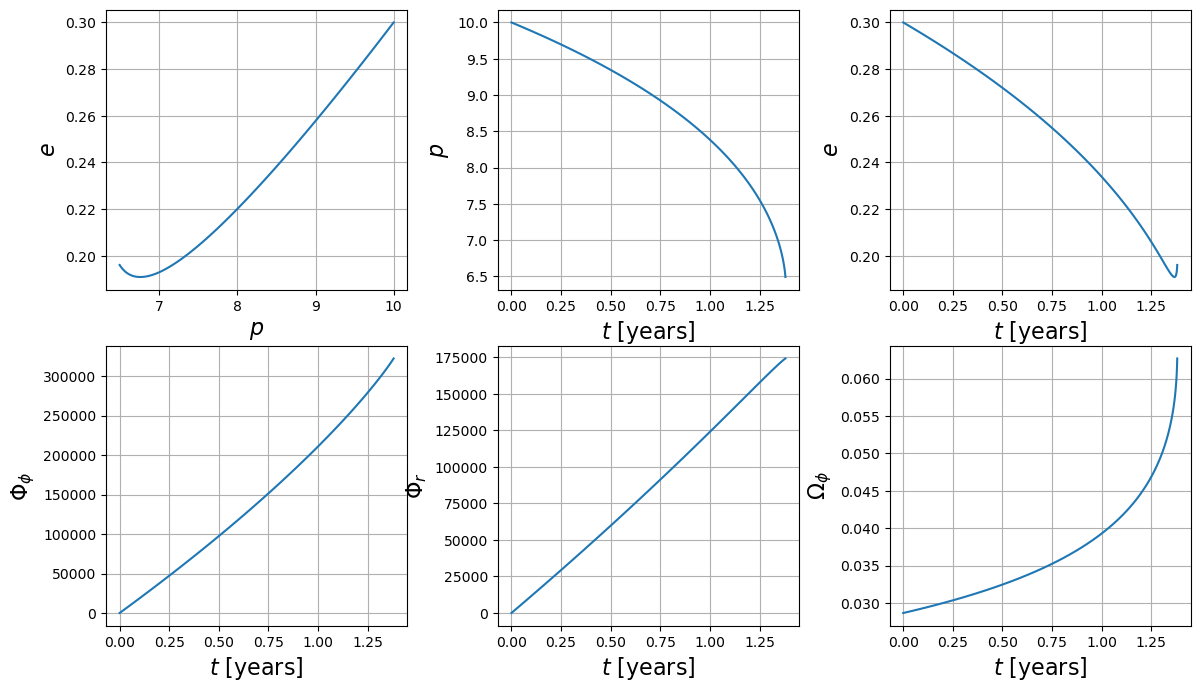

In [104]:
# set initial parameters for Schwarzschild orbit
M = 1e6   # Primary mass  (solar masses)
mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information 
kwargs = dict(dt=10.0, # initial time step, 
              T=2.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)


# get dimensionless fundamental frequencies
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)


# Plot the results
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Omega_\phi$']
xlabels = [r'$p$', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]']
ys = [e, p, e, Phi_phi, Phi_r, OmegaPhi]
xs = [p, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.grid()

## Exercise 0

1. For the default parameters $(M,\mu,a,p_{0},e_{0},(x_{I})_{0}) = (10^{6}, 10, 0, 10, 0.3, 1)$ with $T = 2$ years, verify that the final point in semi-latus rectum corresponds to the separatrix defined by $p = 6 + 2e$. Change the time of evolution $T$ and make a note of what you find. 
2. Modify the mass-ratio of the system above by increasing/decreasing $M$ whilst keeping $\mu$ (and all other parameters) fixed. What do you observe about the orbital evolution in semi-latus rectum $p(t)$? You may need to increase the time of evolution $T$. You will find that $\dot{p} = dp/dt$ decreases as $M$ is increased. 

In [160]:
# EXERCISE 0! 

# set initial parameters for Schwarzschild orbit
# M = 1e6   # Primary mass  (solar masses)
# mu = 1e1  # Secondary mass  (solar masses)
# p0 = 10.0 # range [separatrix, 45]
# e0 = 0.3  # range [0.0, 0.7]

# # run trajectory
# # must include for generic inputs, will fix a = 0 and x = 1.0
# a = 0.0
# x = 1.0

# # additional information 
# kwargs = dict(dt=10.0, # initial time step, 
#               T=2.0, # Time duration in years
#               err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
#              )

# # Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
# t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
#                                               Phi_phi0=0.0,
#                                               Phi_theta0=0.0,
#                                               Phi_r0=0.0,
#                                               **kwargs)

# p_sep = [INSERT YOUR CODE HERE] 
# print("Separatrix is at ",p_sep)
# print("Final point in semi-latus rectum is", p[-1])

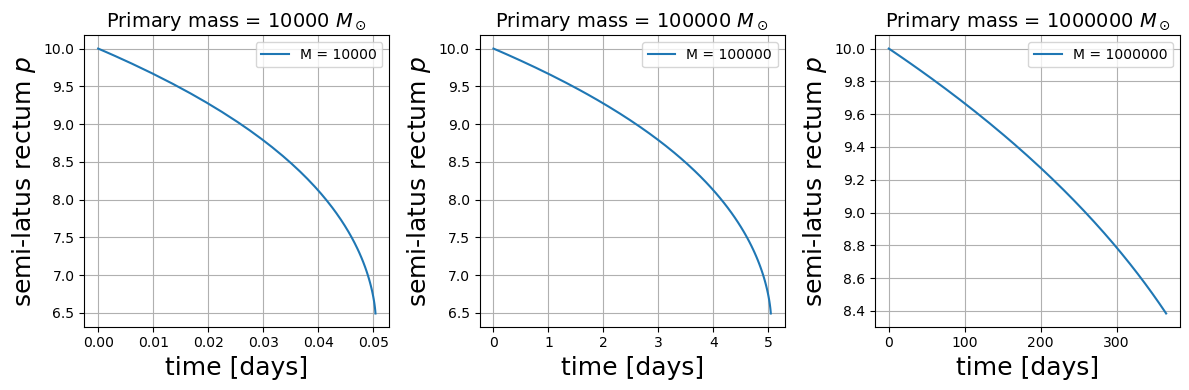

In [161]:
# EXERCISE 0! 

# set initial parameters for Schwarzschild orbit

mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information 
kwargs = dict(dt=10.0, # initial time step, 
              T=1.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)

M_vec = 10**np.arange(4,7,1)
N_plots = len(M_vec)

fig,ax = plt.subplots(1,N_plots, figsize = (12,4))
i=0
for M in M_vec:
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    ax[i].plot(t/60/60/24,p,label = "M = {}".format(M))
    ax[i].set_xlabel(r'time [days]', fontsize = 18)
    ax[i].set_ylabel(r'semi-latus rectum $p$',fontsize = 18)
    ax[i].set_title(r'Primary mass = {} $M_\odot$'.format(M),fontsize = 14)
    ax[i].legend()
    ax[i].grid()
    

    i+=1

plt.tight_layout()

# p_sep = [INSERT YOUR CODE HERE] 
# print("Separatrix is at ",p_sep)
# print("Final point in semi-latus rectum is", p[-1])

### Quasi-Keplerian parameters: $(p,e)$
We want to remark that $p$ and $e$ are quasi-Keplerian parameters and gauge dependent quantities (they depend on the choice of coordinate system). They "converge" to the Newtonian equivalent parameters in the weak field regime (far away in radial coordinate $r$ from the black hole). Below we show a plot of ellipsis based on these parameters at diferent stages of the evolution. This is useful to get a sense of the evolution of the orbit but you should not interpret these ellipsis as real orbits! 

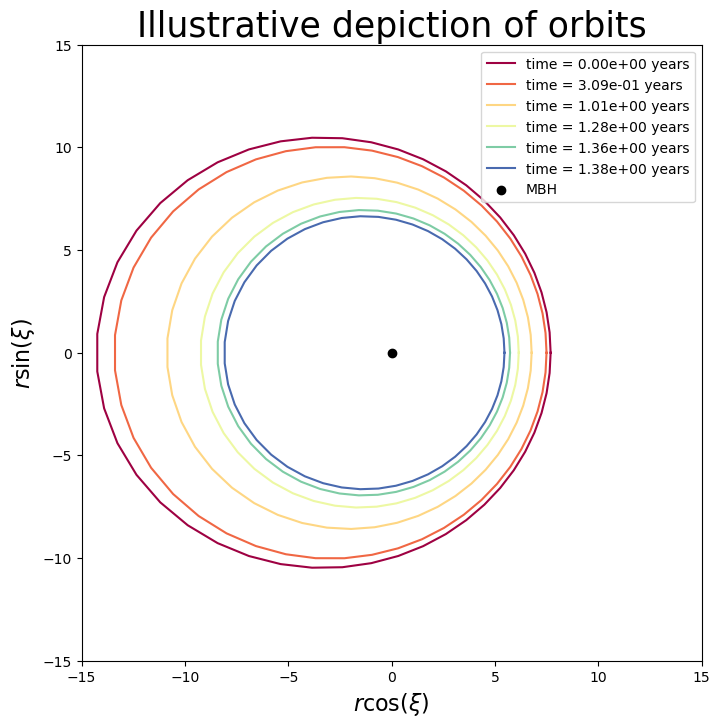

In [6]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

plt.figure(figsize=(8,8))
for ii in range(0,len(p),20):
    pp = p[ii]
    ee = e[ii]
    Csi = np.linspace(0.0,2*np.pi)
    rr = pp / (1 + ee * np.cos(Csi))
    xx = rr * np.cos(Csi)
    yy = rr * np.sin(Csi)
    plt.plot(xx,yy,c=cmap(ii/len(p)),label=f'time = {t[ii]/(YRSID_SI):.2e} years' )
plt.scatter(0,0,c='k',label='MBH')
plt.legend()
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r'$r\cos(\xi)$',fontsize = 16)
plt.ylabel(r'$r\sin(\xi)$', fontsize = 16)
plt.title('Illustrative depiction of orbits',fontsize = 25)
plt.show()

## Evolution of semi-latus rectum and eccentricity

The goal of the next cell is to understand how the semi-latus rectum and eccentricity evolve together. Notice that for trajectories with semi-latus rectum close to the separatrix, one observes an "uptick" in the eccentricity. This is a well known feature and is further discussed in this [article](https://arxiv.org/abs/gr-qc/0203086).

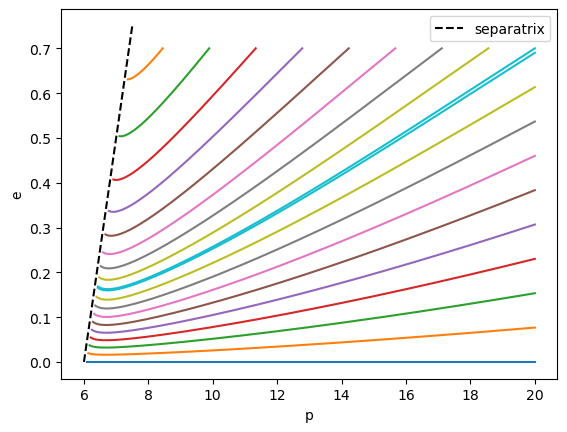

In [7]:
# set initial parameters
M = 1e6     # Primary mass (solar masses)
mu = 1e1    # Secondary mass (solar masses)

# run trajectory

# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information 
kwargs = dict(dt=10.0, # initial time step, 
              T=100.0, # Time duration in years [Excessive, but want to evolve to separatrix! here]
              err=1e-10 # integrator error
             )

p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

plt.figure()


# Here we plot the trajectory with all parameters fixed (e0 = 0.7) apart from p0
for p0 in np.linspace(7, 20, num=10):
    e0=0.7
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
    plt.plot(p,e)

# Now we plot the trajectory with all parameters fixed (p0 = 20) apart from e0
for e0 in np.linspace(0, 0.69, num=10):
    p0=20.0
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
    plt.plot(p,e)

# Separatrix given by p_sep = 6 + 2*e
pp = np.linspace(6,7.5,100)
ecc = (pp - 6)/2
plt.plot(pp,ecc,'k--',label='separatrix')
plt.xlabel('p')
plt.ylabel('e')
plt.legend()
plt.show()


### Trajectory duration as a function of mass ratio, eccentricity, semi-latus rectum

In Exercise 0 above we saw that the length of the trajectory, in time, is very sensitive to the mass-ratio of the system. The coupled ODEs 
\begin{align}
\frac{d}{dt}p &= \epsilon \, f^{(1)}_p(a, p, e, x_I) + \mathcal{O}(\epsilon^2)\\
\frac{d}{dt}e &= \epsilon \, f^{(1)}_e(a, p, e, x_I) + \mathcal{O}(\epsilon^2)\\
\end{align}
show that $\dot{p} \sim \dot{e} \sim \epsilon$. It should then be expected that the rate of change of the orbital parameters $p(t)$ and $e(t)$ is directly proportional to the size of the mass-ratio of the system. We will investigate this below. 


In [203]:
# set initial parameters
M = 1e6   # Primary mass
mu = 1e1  # Secondary mass
p0 = 12 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory

# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (1000 years) so that we obtain the time duration from trajectory

kwargs = dict(dt=10.0, # initial time setp, 
              T=1000.0,
              err=1e-10 # integrator error
             )

mass_ratio_vector = 10**np.linspace(-4.0, -7.0, num=10)

tfinal = []
for count,epsilon in enumerate(mass_ratio_vector):

    # get secondary mass for fixed mass ratio
    mu = M * epsilon
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    
    # inspiral duration (divide by YRSID_SI to get it in years)
    tfinal.append(t[-1]/YRSID_SI) 
    if count%3 == 0:
        print("For a mass-ratio of epsilon = {}, time duration is T = {} years".format(epsilon,t[-1]/YRSID_SI))


For a mass-ratio of epsilon = 0.0001, time duration is T = 0.3967452628006567 years
For a mass-ratio of epsilon = 1e-05, time duration is T = 3.967452550970718 years
For a mass-ratio of epsilon = 1e-06, time duration is T = 39.6745203486156 years
For a mass-ratio of epsilon = 1e-07, time duration is T = 396.74518326623223 years


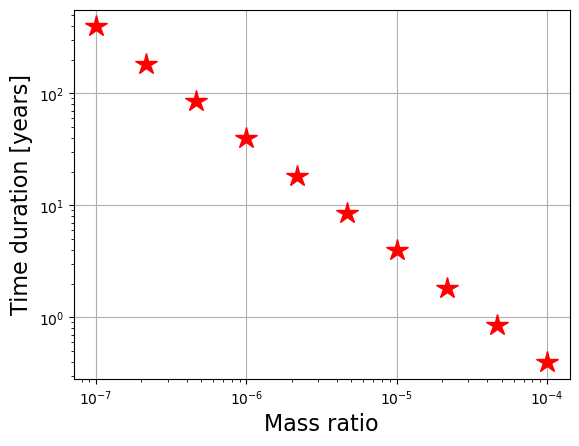

In [206]:
plt.figure()
plt.loglog(mass_ratio_vector, tfinal,'*', ms = "16", c = 'red') 
plt.ylabel('Time duration [years]',fontsize = 16)
plt.xlabel('Mass ratio',fontsize = 16)
plt.title("")
plt.grid()
plt.show()

### Discussion of plot above

In each trajectory calculation, the initial semi-latus rectum is fixed. The only quantity that is changing is the mass ratio $\epsilon = \mu/M$. As $\epsilon$ decreases, the trajectory evolution time increases. The time of evolut ion is thus inversely proportional to the mass-ratio of the system. We thus see that 

\begin{equation}
T_{\text{observation}} \sim 1/\epsilon
\end{equation}

Notice that for $\epsilon = 10^{-7}$, with the parameters given above, it would have taken 396 years to plunge. Whereas with a mass-ratio of $\epsilon = 10^{-4}$, it would have only taken 144 days.  

Cool.

## Exercise 1

Let us now understand how the inspiral duration changes for different initial eccentricity or different initial semi-latus rectum. Remember the range of validity of the parameters and produce two plots:
1. Time duration vs initial eccentricity (fixing all the other parameters)
2. Time duration vs initial semi-latus rectum (fixing all the other parameters)

If you have time, produce also this plot:

3. Time duration vs M/epsilon (M=Mass MBHS and epsilon=Mass ratio). Prove that, for different total masses and mass ratios, the behavior of Time duration vs M/epsilon is always the same (Hint: use two for loops, one for $M$ and the other for $\epsilon$).

You should find that:

1. The relation between time-duration and eccentricity is weak
2. The relation between time-duration and semi-latus rectum is near-linear
3. The relation between time-duration and $M/\epsilon$ is perfectly linear. 

In [10]:
# Time duration vs initial eccentricity -- It's your turn! 

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp, 
              T=1000.0,
              err=1e-10 # integrator error
             )

# ecc = np.linspace(0.01, 0.7, num=10)

# tfinal = []
# for e0 in ecc:

#  [INPUT YOUR CODE IN HERE]
    
#     tfinal.append(t[-1]/YRSID_SI) 


# plt.figure()
# plt.plot(ecc, tfinal) 
# plt.ylabel('Time duration [years]')
# plt.xlabel('e0')
# plt.show()



In [11]:
# Time duration vs initial semi-latus rectum

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp, 
              T=1000.0,
              err=1e-10 # integrator error
             )

# tfinal = []
# e0 = 0.0 # reset eccentricity
# pp = np.linspace(7.0, 30.0, num=10)
# for p0 in pp:

#  [INPUT YOUR CODE IN HERE]

#     tfinal.append(t[-1]/YRSID_SI) 


# plt.figure()
# plt.loglog(pp, tfinal) 
# plt.ylabel('Time duration [years]')
# plt.xlabel('p0')
# plt.show()





In [12]:

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp, 
              T=1000.0,
              err=1e-10 # integrator error
             )

# tfinal = []
# e0 = 0.2 # reset
# p0=10.0

# epsilon_vector = 10**np.linspace(-4.0, -6.0, num=10)
# Mvec = 10**np.linspace(4.0, 7.0, num=10)

# plt.figure()
# for M in [CODE HERE]:
#     tfinal = []
#     for epsilon in [CODE HERE]:

#         # get secondary mass for fixed mass ratio
        
#         mu = [CODE HERE]
#         CODE HERE -- Generate your trajectory for given choices of M and epsilon. 

#         # inspiral duration (divide by YRSID_SI to get it in years)
#         tfinal.append(t[-1]/YRSID_SI) 

    # plt.plot(M/epsilon_vector, tfinal) 
# plt.ylabel('Time duration [years]')
# plt.xlabel('$M/\epsilon$')
# plt.show()

### Number of cycles and differences between trajectories
It is often common to introduce the number of cycles $\mathcal{N}_\varphi (t)= \Phi_\varphi(t)/(2\pi)$ to quantify the number of times the compact object orbits around the MBH. This is useful to quantify the difference between trajectories.

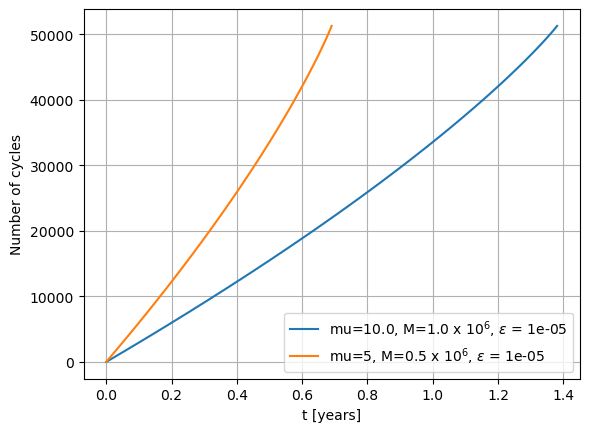

Final number of cycles of system 1 with mu = 10.0 and M = 1000000.0 is N_cyles = 51298.48461545311
Final number of cycles of system 2 with mu = 5 and M = 500000.0 is N_cycles = 51298.48113547578


In [13]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M1 = 1e6
mu1 = 1e1

t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M1, mu1, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

plt.figure()
plt.plot(t1/YRSID_SI,Phi_phi1/(2*np.pi), label=f'mu={mu1}, M={M1/1e6} x $10^6$, $\epsilon$ = {mu1/M1}') 
plt.plot(t2/YRSID_SI,Phi_phi2/(2*np.pi), label=f'mu={mu2}, M={M2/1e6} x $10^6$, $\epsilon$ = {mu2/M2}')
plt.ylabel('Number of cycles')
plt.xlabel('t [years]')
plt.legend()
plt.grid()
plt.show()

print("Final number of cycles of system 1 with mu = {} and M = {} is N_cyles = {}".format(mu1,M1,Phi_phi1[-1]/(2*np.pi)))
print("Final number of cycles of system 2 with mu = {} and M = {} is N_cycles = {}".format(mu2,M2,Phi_phi2[-1]/(2*np.pi)))

The two systems have the same mass ratio and the same final number of cycles. However, the number of cycles accumulated per second is different. An EMRI system with larger MBH "more slowly" than a system with smaller `M`.  Notice that the frequencies are related to the time derivative of the number of cycles
$$
\frac{d}{dt} \mathcal{N}_\varphi = \frac{1}{2 \pi}\frac{d}{dt} \Phi_\varphi = \frac{1}{2 \pi} \Omega_\varphi
$$

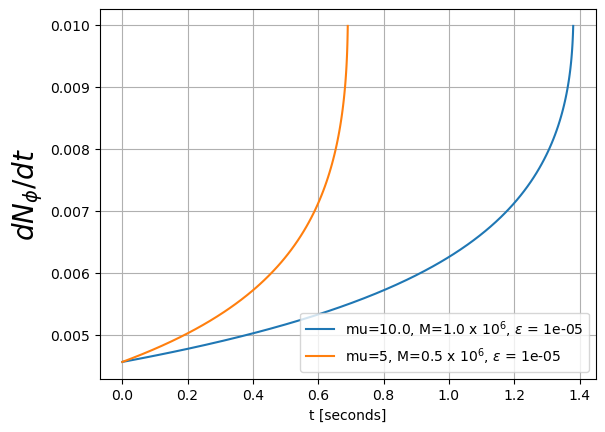

In [14]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M1 = 1e6
mu1 = 1e1

epsilon = mu/M



t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M1, mu1, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

OmegaPhi1, OmegaTheta1, OmegaR1 = get_fundamental_frequencies(a, p1, e1, xI1)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, xI1,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

OmegaPhi2, OmegaTheta2, OmegaR2 = get_fundamental_frequencies(a, p2, e2, xI2)

plt.figure()
plt.plot(t1/YRSID_SI,OmegaPhi1/(2*np.pi), label=f'mu={mu1}, M={M1/1e6} x $10^6$, $\epsilon$ = {mu1/M1}') 
plt.plot(t2/YRSID_SI,OmegaPhi2/(2*np.pi), label=f'mu={mu2}, M={M2/1e6} x $10^6$, $\epsilon$ = {mu2/M2}')
plt.ylabel(r'$dN_{\phi}/dt$',fontsize = 20)
plt.xlabel('t [seconds]')
plt.legend()
plt.grid()
plt.show()


## Exercise 2
Plot the FINAL number of cycles (`Ncycle.append(Phi_phi[-1]/(2*np.pi))`) for different mass ratios. What do you find? If you see a linear relationship then well done!!!

In [15]:
# # set initial parameters
M = 1e6
mu = 1e1

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# Ncycle = []
# for epsilon in epsilon_vector:

#     # get secondary mass for fixed mass ratio
#     mu = [CODE HERE]
#     t, p, e, xI, Phi_phi, Phi_theta, Phi_r = [CODE HERE]
    
#     Ncycle.append([CODE HERE]) 
    

# plt.figure()
# plt.loglog(mass_ratio_vector, Ncycle) 
# plt.ylabel('Number of cycles')
# plt.xlabel('Mass ratio')
# plt.show()

### Fundamental frequencies and harmonics

An EMRI Waveform can thought as a Fourier series where the frequencies $\omega_{mnk}$ are given by
$$
\omega_{mnk} = m \Omega_\varphi + n \Omega_r + k \Omega_\theta
$$
Therefore is possible to plot the frequency evolution of each harmonic given a trajectory. This can be useful to understand which frequency range each harmonic spans.

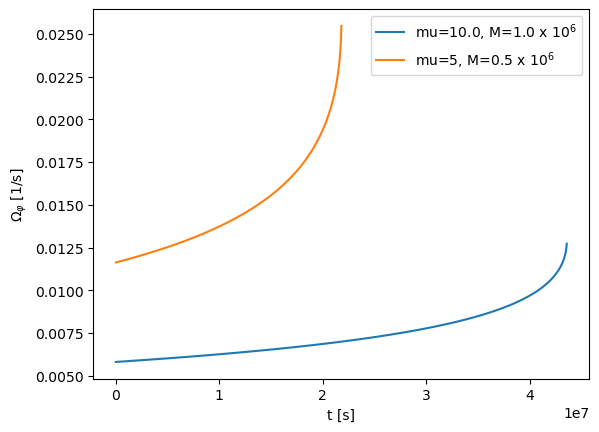

In [17]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M = 1e6
mu = 1e1

t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
# get the fundamental frequencies
OmegaPhi1, OmegaTheta1, OmegaR1 = get_fundamental_frequencies(a, p1, e1, xI1)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
OmegaPhi2, OmegaTheta2, OmegaR2 = get_fundamental_frequencies(a, p2, e2, xI2)

plt.figure()
# we need to divide by the total Mass and convert to seconds
plt.plot(t1,OmegaPhi / (M1 * MTSUN_SI) , label=f'mu={mu1}, M={M1/1e6} x $10^6$') 
plt.plot(t2,OmegaPhi2/ (M2 * MTSUN_SI), label=f'mu={mu2}, M={M2/1e6} x $10^6$')
plt.ylabel(r'$\Omega_\varphi$ [1/s]')
plt.xlabel('t [s]')
plt.legend()
plt.show()

The system with smaller MBH mass spans more frequencies and evolves more quickly than the system with larger MBH mass. This piece of code will be exceptionally useful for a later exercise. Understand here that, for the $\phi$ angular frequency $m\Omega_{\phi}$, we can determine up to what mode in $m$ we are sensitive to when analysing EMRI waveforms.

## Schwarzchild Waveforms in the source frame
Here we show how to get the final waveform using the input parameters.

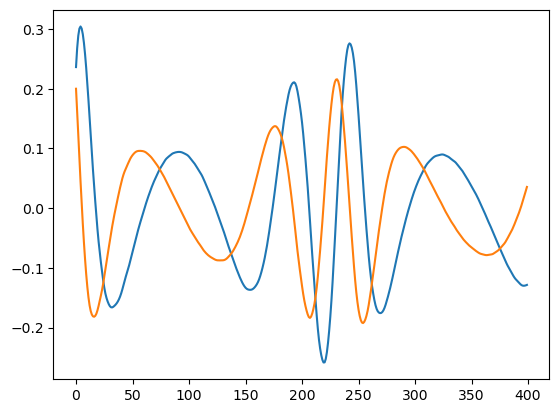

In [20]:
few_gen = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi,Phi_phi0=0.0,  dt=dt, T=0.01)  #  assumes dt = 10.0 for max T = 0.01 year

plt.figure()
plt.plot(wave.real[:400])
plt.plot(wave.imag[:400])
plt.show()

## EMRI Waveforms in different domains
The output of FEW is a time domain waveform, i.e. the dimensionless strain as a function of time. We are working on providing waveforms directly in Fourier and Time-Frequency domain.

In [21]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.0
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0
# notice that we are providing the distance parameter
wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)  #  assumes dt = 10.0 for max T = 1.0 year
time = np.arange(0, len(wave))*dt

## Time Domain

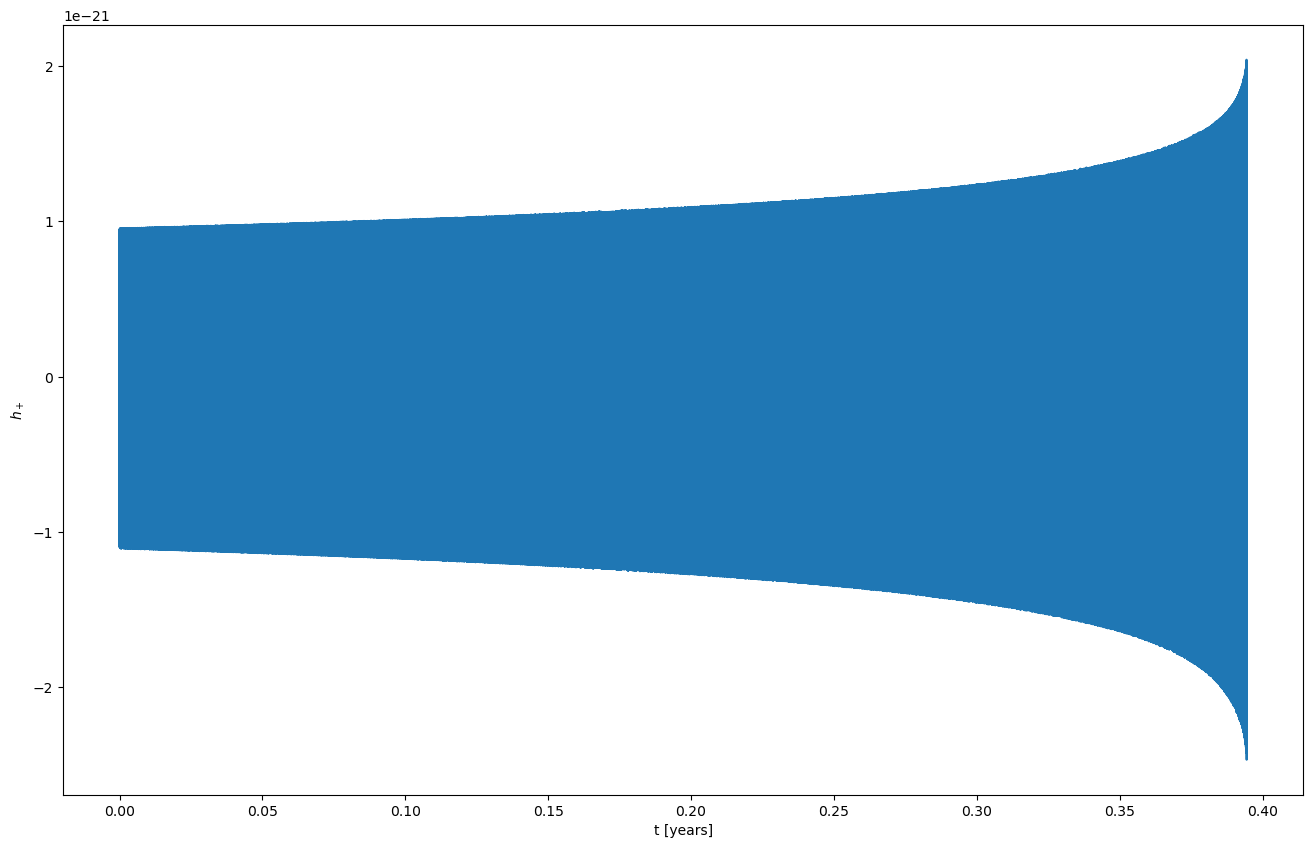

In [25]:
plt.figure(figsize=(16,10))
plt.plot(time/YRSID_SI, wave.real)
plt.ylabel(r'$h_+$')
plt.xlabel('t [years]')
plt.show()

## Fourier Domain

In [26]:
# load Power Spectral Density of LISA. This represents how loud the instrumental noise is.
noise = np.genfromtxt("LPA.txt", names=True)
f, PSD = (
    np.asarray(noise["f"], dtype=np.float64),
    np.asarray(noise["ASD"], dtype=np.float64) ** 2,
)

# here we use a cubic spline to interpolate the PSD
sens_fn = CubicSplineInterpolant(f, PSD, use_gpu=False)

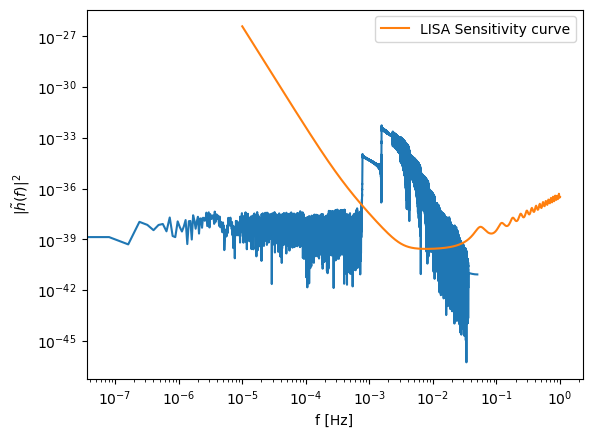

In [27]:
# we take the Fast Fourier transform of the signal
hp_fft = np.fft.rfft(wave.real)*dt
hx_fft = -np.fft.rfft(wave.imag)*dt

freq = np.fft.rfftfreq(len(wave),dt)
plt.figure()
plt.loglog(freq, np.abs(hx_fft)**2)
plt.plot(f, PSD,label='LISA Sensitivity curve')
plt.legend()
plt.ylabel(r'$|\tilde{h}(f)|^2$')
plt.xlabel('f [Hz]')
plt.show()

We define the inner product:
$$
<{a (t)}|{b (t)}> =4 \Re \int _{0} ^\infty \frac{\tilde{a} ^* (f) \tilde{b} (f) }{S_n (f)} \, {\rm d} f \, .
$$
where the tilde indicates the Fourier transform, the symbol $^*$ indicates the complex conjugation, and $S_n (f)$ is the one-sided noise power spectral density, which can be interpreted as the size of the root mean square fluctuations at a given frequency $\Delta n _{\text{rms}} \sim \sqrt{S_n(f) \Delta f}$. From a practical point of view the spectral density represents our information on the detector sensitivity and the aforementioned inner product can be used to quantify the Signal to Noise Ratio (SNR) of a waveform $h(t)$:
$$
{\rm SNR}^2 =<{h (t)}|{h (t)}> =4 \Re \int _{0} ^\infty \frac{|\tilde{h} (f)| }{S_n (f)} \, {\rm d} f \approx 4 \Re \sum_{i=0}^{N/2 - 1}\frac{|\tilde{h}(f_{i})|^2}{S_{n}(f_{i})}\Delta f\, .
$$
for $\Delta f$ the spacing between frequencies defined by $\Delta f = 1/N\Delta t = 1/T_{\text{observation}}$. 
EMRIs are usually considered to be detectable for $SNR\gtrsim 15$ or so  

In [28]:
def inner_product(a,b,dt):
    a_tilde = np.fft.rfft(a)*dt
    b_tilde = np.fft.rfft(b)*dt
    freq = np.fft.rfftfreq(len(a),dt)
    df = freq[1]-freq[0]
    psd_f = sens_fn(freq)
    return 4.0 * np.real ( np.sum( np.conj(a_tilde) * b_tilde * df / psd_f) )

# the SNR of the previous waveform is
SNR = np.sqrt(inner_product(wave.real,wave.real,dt))
print("SNR =",SNR)

SNR = 115.1163351387092


/opt/homebrew/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.4.6-py3.7-macosx-10.9-x86_64.egg/few/summation/interpolatedmodesum.py:202: UserWarning: New t array outside bounds of input t array. These points are filled with edge values.
  "New t array outside bounds of input t array. These points are filled with edge values."


### Exercise 5
Verify that the SNR of an EMRI waveform is:
- inversely proportional to the distance
- directly proportional to the secondary mass `mu` for fixed total Mass and duration. Make sure that the source does not plunge before the times provided. Otherwise, you might not get the direct proportionality, i.e. set T=`0.001` and vary $\mu\in[10,100]$.


In [38]:
# your turn

# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

# plt.figure()
# for dd in np.linspace(1.0,5.0,num=10):
#     wave = few_gen(M, mu, p0, e0, theta, phi, dist=dd, dt=dt, T=0.001)
#     SNR = [INSERT YOUR CODE HERE ] 
#     plt.plot([INSERT YOUR CODE HERE]) 
    
# plt.xlabel('1/d')
# plt.ylabel('SNR')
# plt.show()


# plt.figure()
# for mu in np.linspace(1.0,100.0,num=10):
#     wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001)
#     SNR = [INSERT YOUR CODE HERE]
#     plt.plot([INSERT YOUR CODE HERE])
# plt.xlabel('mu')
# plt.ylabel('SNR')
# plt.show()

We will now introduce another quantity which will be useful for estimating qualitatively how different two waveforms $a(t)$ and $b(t)$ are. We define the ehe Overlap $\mathcal{O}(a,b)$ between two waveform models $a$ and $b$ by: 
$$
\mathcal{O} (a,b) = \frac{<{a}|{b}>}{\sqrt{<{a}|{a}>} \sqrt{<{b}|{b}>}} \in [-1,1] \, .
$$
The overlap expresses how similar two signals $a$ and $b$ by weighting the product with the power spectral density of the detector $S_n (f)$. If two signals are identical then the overlap is 1. Another quantity often used in gravitational wave data analysis is the mismatch which is defined as 1 minus the overlap.

In [59]:
def overlap(a,b,dt):
    a_b = inner_product(a,b,dt)
    a_a = inner_product(a,a,dt)
    b_b = inner_product(b,b,dt)
    return a_b / np.sqrt(a_a * b_b)

print("overlap of a signal with itself = ",overlap(wave.real,wave.real,dt))

overlap of a signal with itself =  1.0


In [93]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001)
t_base = np.arange(0,len(base_sig)*dt,dt)

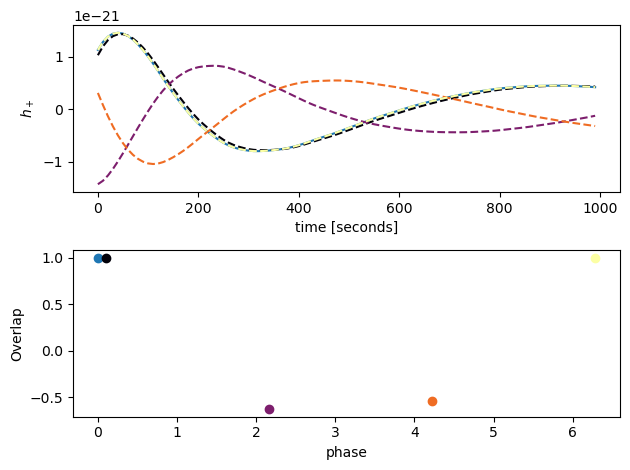

In [98]:
cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(2, 1)
axs[0].plot(t_base[:100],base_sig.real[:100])
axs[1].scatter(0.0, 1)
axs[1].set_xlabel('phase')
axs[1].set_ylabel('Overlap')
axs[0].set_ylabel('$h_+$')
for phase in np.linspace(0.1, 2*np.pi,num=4):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001) * np.exp(1j*phase)
    t_wave = np.arange(0,len(wave)*dt,dt)
    O = overlap(base_sig.real,wave.real,dt)
    axs[0].plot(t_wave[0:100],wave.real[0:100],'--', color= cmap(phase/(np.pi*2)))
    axs[0].set_xlabel(r'time [seconds]')
    axs[1].scatter(phase, O, color= cmap(phase/(np.pi*2)))
    
plt.tight_layout()

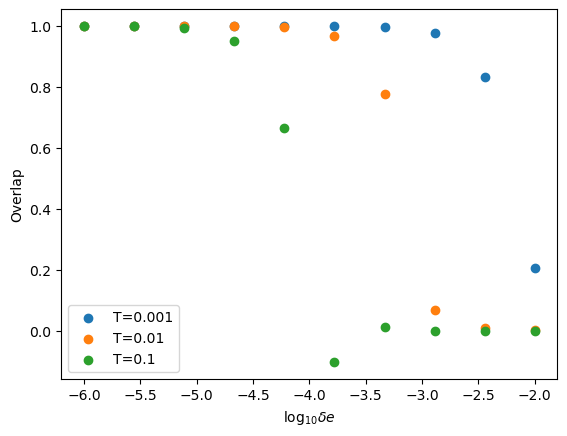

In [62]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0
T = 0.01

cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(1, 1)
axs.set_xlabel('$\log_{10}\delta e$')
axs.set_ylabel('Overlap')
vec = 10**np.linspace(-6, -2,num=10)  # Here we will add small perturbations to parameters 
logd = np.log10(vec)

for T in [0.001, 0.01, 0.1]:
    base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O=[]    
    for delta in vec:
        wave = few_gen(M, mu, p0, e0*(1+delta), theta, phi, dist=1.0, dt=dt, T=T)
        O.append(overlap(base_sig.real,wave.real,dt))

    axs.scatter(logd, O , label=f'T={T}')

plt.legend()
plt.show()

### Exercise 6
Repeat the previous plot by varying each of the EMRI parameters. Which parameter makes the overlap drop faster?

In [35]:
# # your turn

# # parameters
# M = 1e6
# mu = 1e2
# p0 = 12.0
# e0 = 0.4
# theta = np.pi/3  # polar viewing angle in source frame
# phi = np.pi/4  # azimuthal viewing angle in source frame
# dt = 10.0
# T = 0.01

# cmap = matplotlib.cm.get_cmap('inferno')
# fig, axs = plt.subplots(1, 1)
# axs.set_xlabel('$\log_{10}\delta e$')
# axs.set_ylabel('Overlap')
# vec = 10**np.linspace(-6, -2,num=10)
# logd = np.log10(vec)

# T=0.01
# base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
# # M
# O=[]    
# for delta in vec:
#     wave = few_gen([INSERT CODE HERE], mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'M')

# # mu
# O=[]    
# for delta in vec:
#     wave = few_gen(M, [INSERT CODE HERE], p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'mu')

# # p0
# O=[]    
# for delta in vec:
#     wave = few_gen(M, mu, [INSERT CODE HERE], e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'p0')


# plt.legend()
# plt.show()


## Time-Frequency Domain

In [63]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.0
theta = np.pi/3  # polar viewing angle in source frame()
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)

In [64]:
from scipy import signal
# short fourier transform of the signal
f, t, Zxx = signal.stft(wave.real, 1/dt, nperseg=5000)

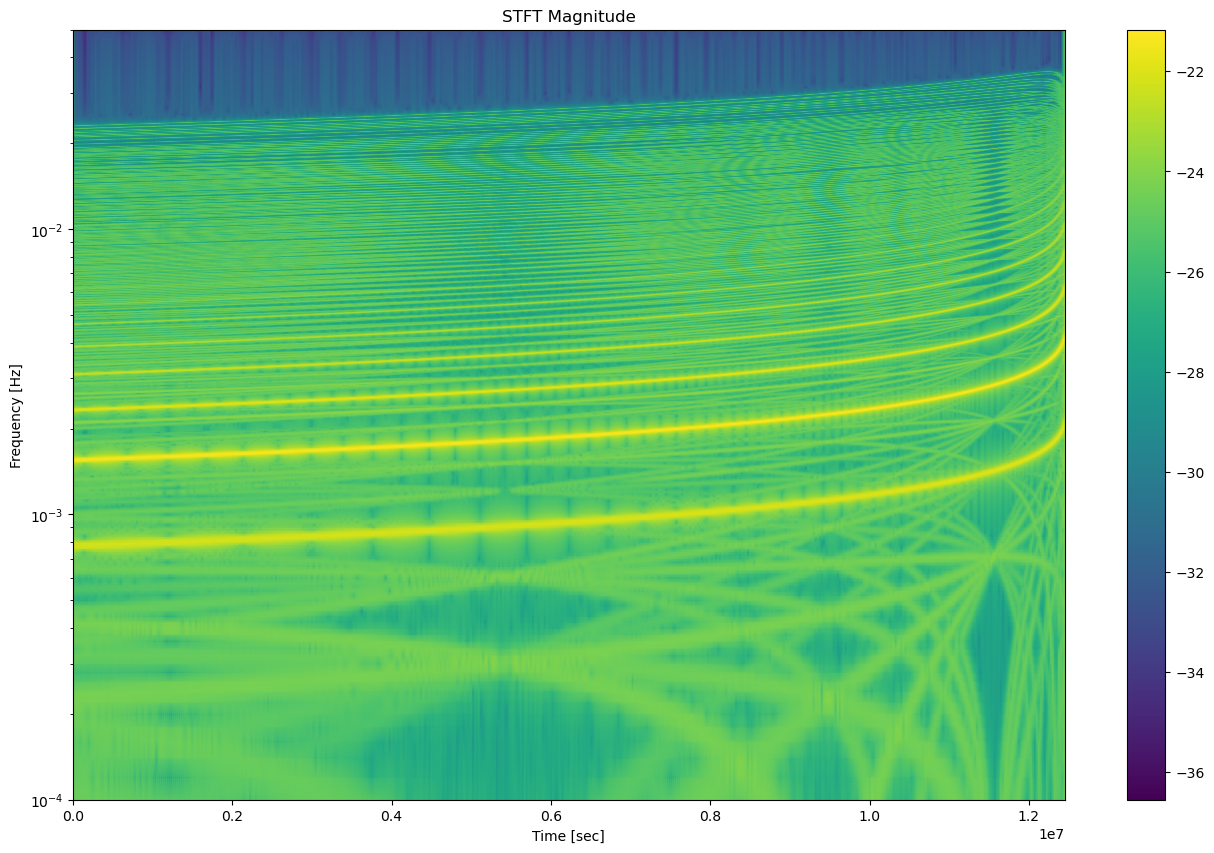

In [65]:
plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
plt.colorbar(cb,)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([1e-4, f[-1]])
plt.show()

### Exercise 7
In the previous plot the different harmonics of the waveform can be recognized as tracks in time-frequency space. As exercise, try to plot the frequency tracks as a function of time on top of the previous plot. Take the same input parameters and run a trajectory to obtain the `p` and `e` evolution. Then pass these arrays into the the function `get_fundamental_frequencies` and obtain the three fundamental frequencies. Then convert to the correct units and plot the frequency $f=(m \Omega_\varphi + n \Omega_r)/(2\pi)$ for some values of your choice for $m$ and $n$.

In [106]:
# your turn

M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.0
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)
f, t, Zxx = signal.stft(wave.real, 1/dt, nperseg=5000)

time, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=1.0, dt=dt)
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 1.0)



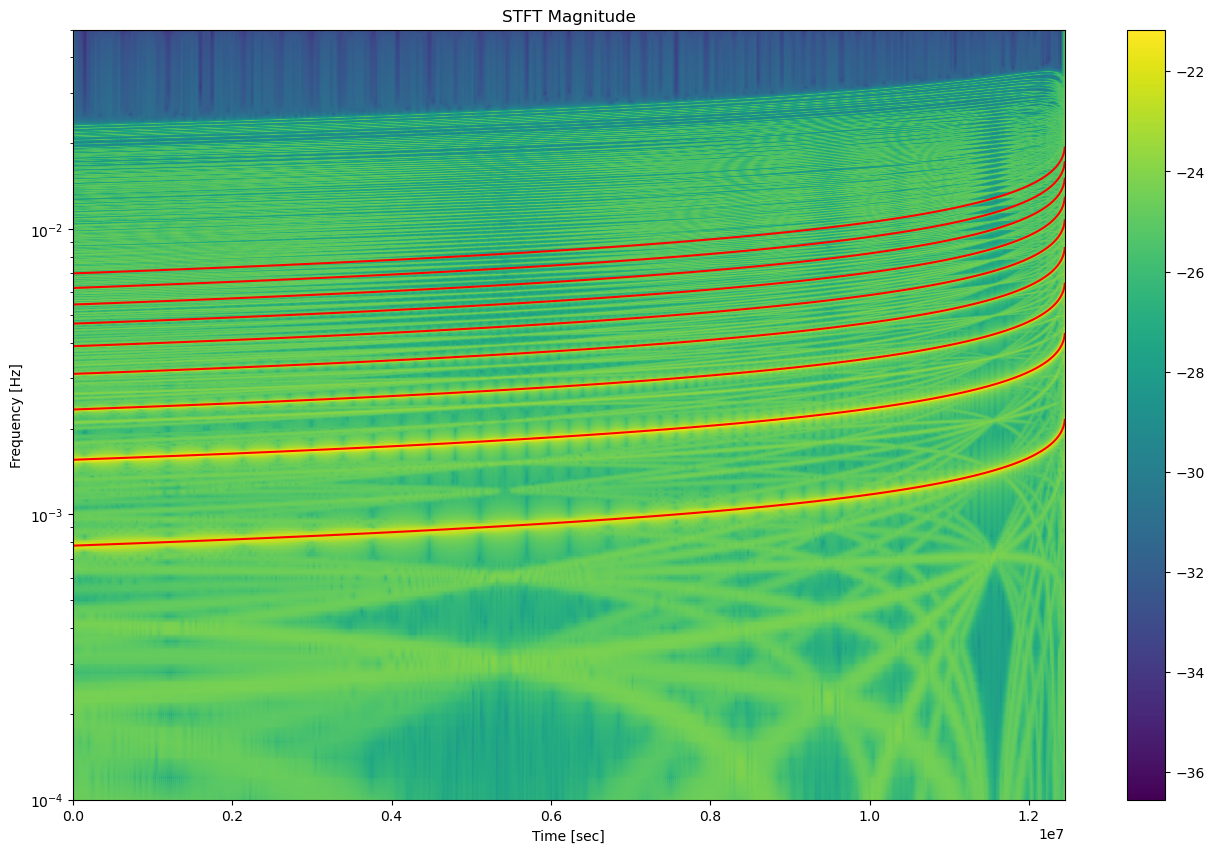

In [107]:
fharmonics_phi = [m*OmegaPhi / (M*MTSUN_SI) / (np.pi*2) for m in range(1,10)]
fharmonics_r = [n*OmegaR / (M*MTSUN_SI) / (np.pi*2) for n in range(1,10)]

m = 5
n = 5

f_combo_r_phi = (m*OmegaPhi + n*OmegaR)/(M*MTSUN_SI)/(np.pi*2)
plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
for j in range(0,9):
    plt.plot(time, fharmonics_phi[j],'r')
#     plt.plot(time,fharmonics_r[j],'white', linestyle='--')\
#     plt.plot(time,f_combo_r_phi, c = 'red', linestyle = '--')
plt.colorbar(cb,)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([1e-4, f[-1]])

plt.show()

# End of Tutorial

## Exercise 3

Make the following plots
- `OmegaPhi /OmegaR` as a function of time for different values of `e0`
- `OmegaPhi /OmegaTheta` as a function of time for different values of `e0`

Then make a note of what you observe. 

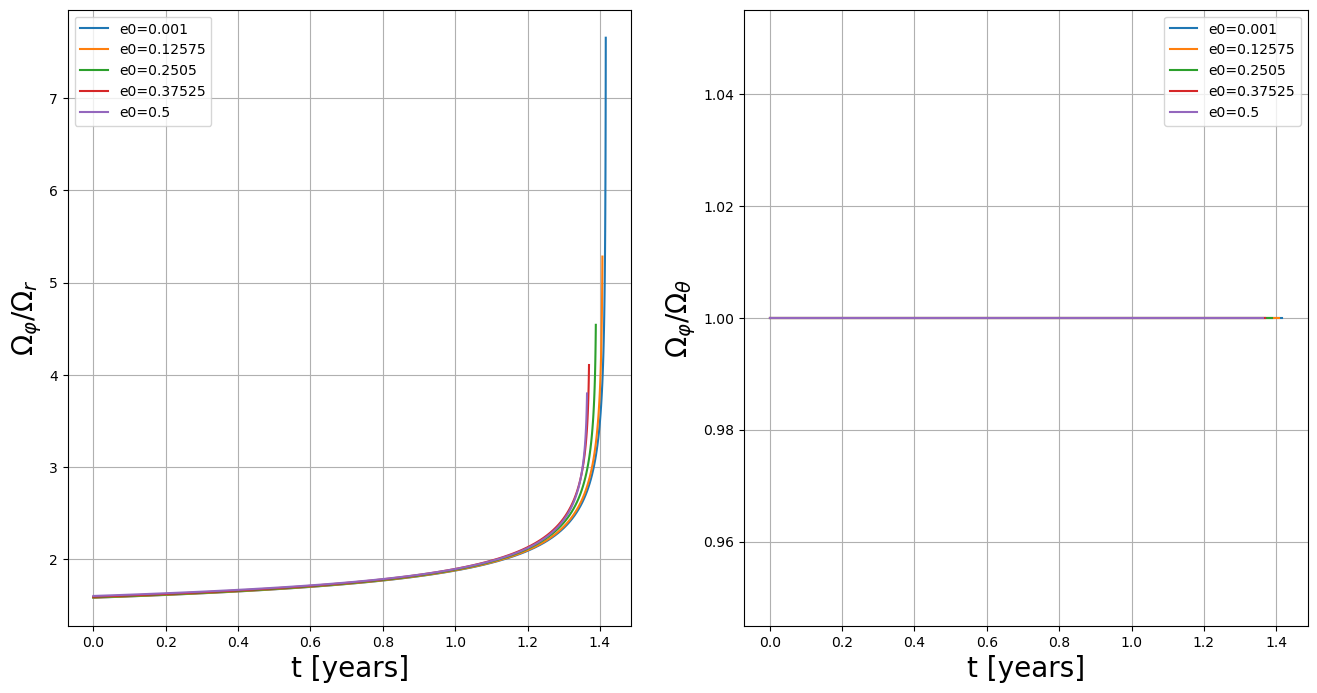

In [19]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M = 1e6
mu = 1e1
fig,ax = plt.subplots(1,2, figsize = (16,8))
kwargs['T'] = 400
for e0 in np.linspace(0.001, 0.5,num=5):
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)
    # we need to divide by the total Mass and convert to seconds
    ax[0].plot(t/YRSID_SI,OmegaPhi /OmegaR , label=f'e0={e0}') 
    ax[1].plot(t/YRSID_SI,OmegaPhi /OmegaTheta, label = f'e0={e0}') 


ax[0].set_ylabel(r'$\Omega_\varphi/\Omega_r$ ',fontsize = 20)
ax[1].set_ylabel(r'$\Omega_\varphi/\Omega_\theta$ ',fontsize = 20)

for i in range(2):
    ax[i].set_xlabel('t [years]', fontsize = 20)
    ax[i].legend()
    ax[i].grid()
plt.show()

## Augmented Analytic Kludge with 5PN trajectory

We have now implemented a new version of the Augmented Analytic Kludge with 5PN trajectories.

Waveforms are generated based on the Augmented Analytic Kludge given in the [EMRI Kludge Suite](https://github.com/alvincjk/EMRI_Kludge_Suite/). However, here the trajectory is vastly improved by employing the 5PN fluxes for generic Kerr orbits from [Fujita & Shibata (2020)](https://arxiv.org/abs/2008.13554). 

The 5PN trajectory produces orbital and phase trajectories. The trajectory is calculated until the orbit reaches within 0.2 of the separatrix, determined from [Stein and Warburton (2020)](https://arxiv.org/abs/1912.07609/). The
fundamental frequencies along the trajectory at each point are then calculated from the orbital parameters and the spin value given by [Schmidt (2002)](https://arxiv.org/abs/gr-qc/0202090>).

These frequencies along the trajectory are then used to map to the frequency basis of the [Analytic Kludge](https://arxiv.org/abs/gr-qc/0310125). This mapping takes the form of time evolving large mass and spin parameters, as
well as the use of phases and frequencies in $\alpha, \Phi, \gamma$:

\begin{align}
\Phi &= \Phi_\phi, \\
\gamma &= \Phi_\phi + \Phi_\theta, \\
\alpha &= \Phi_\phi + \Phi_\theta + \Phi_r. \\
\end{align}


The frequencies in that basis are found by taking the time derivatives
of each equation above.

**Please note:** the 5PN trajectory and AAK waveform take the parameter $Y\equiv\cos{\iota}=L/\sqrt{L^2 + Q}$ rather than $x_I$ as is accepted for relativistic waveforms and in the generic waveform interface discussed above. The generic waveform interface directly converts $x_I$ to $Y$. 

This class has GPU capabilities and works from the sparse trajectory methodoligy with cubic spine interpolation of the smoothly varying waveform quantities. This waveform does not have the freedom in terms of user-chosen quantitites that
`few.waveform.SchwarzschildEccentricWaveformBase` contains. This is mainly due to the specific waveform constructions particular to the AAK/AK.


In [33]:
use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is available for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)

# set initial parameters
M = 1e6
mu = 1e1
a = 0.2
p0 = 14.0
e0 = 0.6
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.2
Phi_theta0 = 1.2
Phi_r0 = 0.8


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

waveform = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, 
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

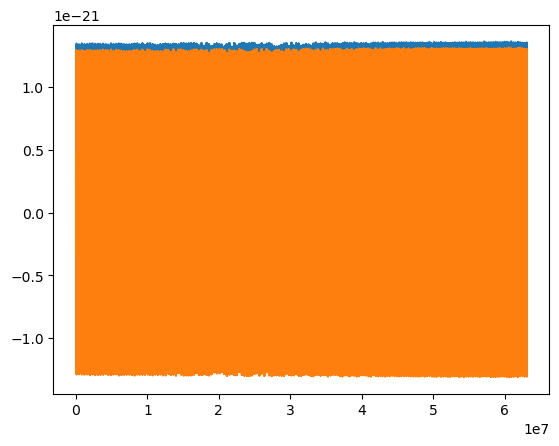

In [31]:
t = np.arange(len(waveform)) * dt
plt.plot(t, waveform.real)
plt.plot(t, waveform.imag)

We can also assume a long-wavelength LISA response by setting `mich=True`. Please note this is not Time-delay interferometry (TDI).

In [32]:
waveform_lw = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, mich=True, dt=dt, T=T)

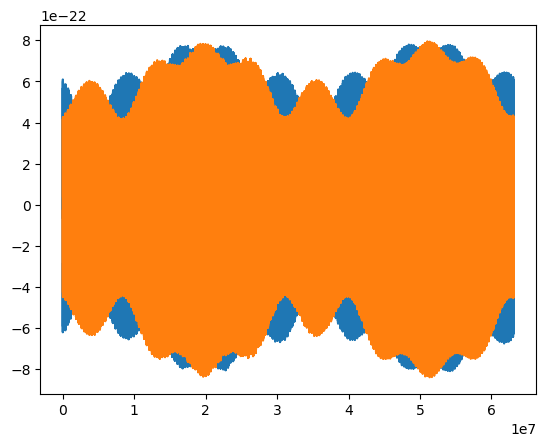

In [48]:
t = np.arange(len(waveform_lw)) * dt
plt.plot(t, waveform_lw.real)
plt.plot(t, waveform_lw.imag)

### 5PN Trajectory

This new waveform includes 5PN trajectories from [Fujita & Shibata 2020](https://arxiv.org/abs/2008.13554).

In [49]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5")

In [50]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0, 
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

140 4.530571061589189


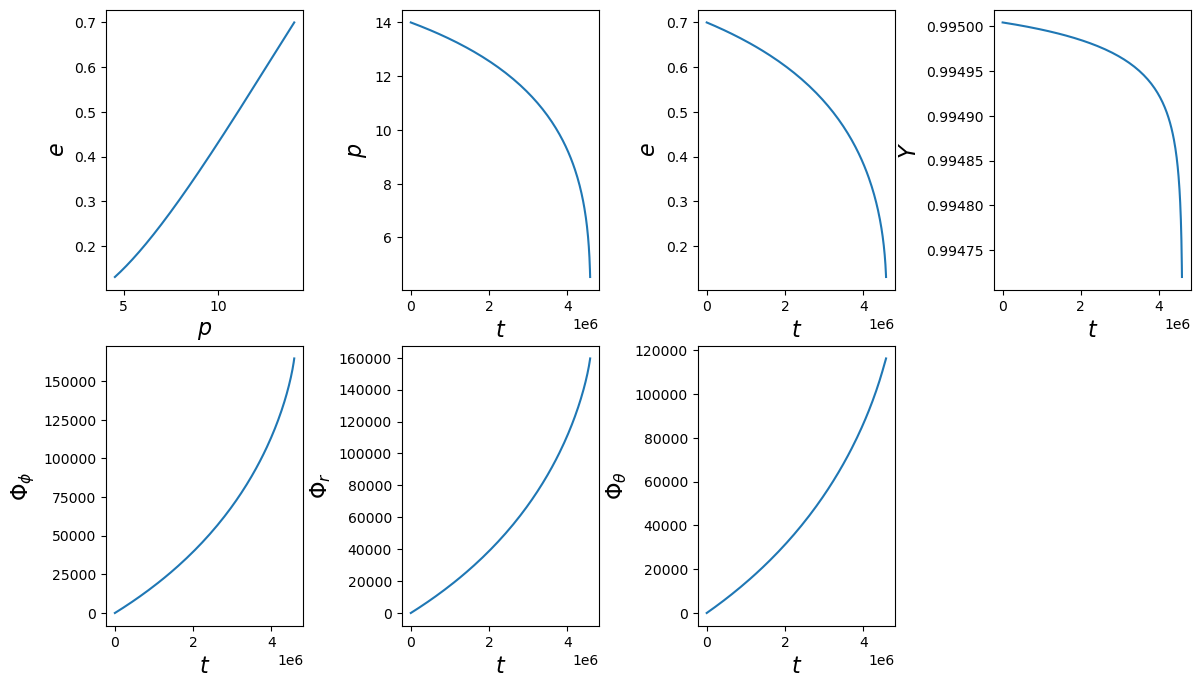

In [51]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    
axes[-1].set_visible(False)

With the PN trajectory, we need to be careful at smaller $p$, larger $a$, and larger $e$. This trajectory can exihibt pathological behavior near these extremes. Therefore, we provide the option to truncate the trajectory at the Schwarzschild ($a=0$) separatrix, $6 + 2e$. To do this, you provide the keyword `enforce_schwarz_sep=True` to the initialization of the class.

In [52]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5", enforce_schwarz_sep=True)

In [53]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0, 
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

104 6.549942276116756


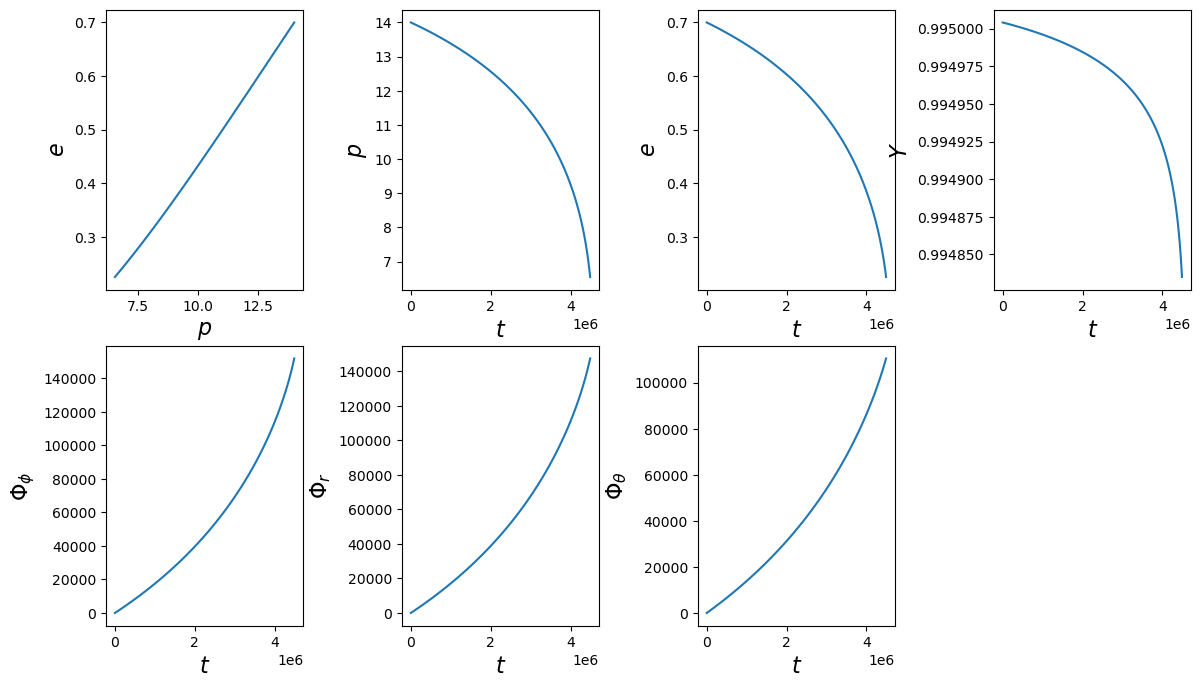

In [54]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    
axes[-1].set_visible(False)

### Building an AAK waveform from a given trajectory (in this case the 5PN trajectory)

In [55]:
from few.utils.baseclasses import Pn5AAK, ParallelModuleBase

class NewPn5AAKWaveform(AAKWaveformBase, Pn5AAK, ParallelModuleBase):
    def __init__(
        self, inspiral_kwargs={}, sum_kwargs={}, use_gpu=False, num_threads=None
    ):

        inspiral_kwargs["func"] = "pn5"

        AAKWaveformBase.__init__(
            self,
            EMRIInspiral,  # trajectory class
            AAKSummation,
            inspiral_kwargs=inspiral_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            num_threads=num_threads,
        )

        

In [56]:
# set initial parameters
M = 1e6
mu = 1e1
a = 0.2
p0 = 14.0
e0 = 0.6
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.2
Phi_theta0 = 1.2
Phi_r0 = 0.8


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

wave_generator = NewPn5AAKWaveform()
AAK_out = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, 
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

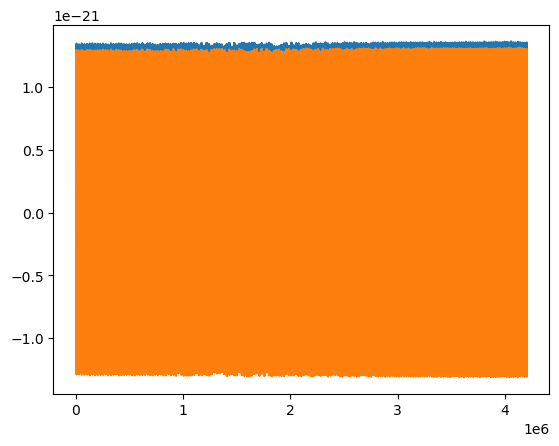

In [57]:
plt.plot(AAK_out.real)
plt.plot(AAK_out.imag)

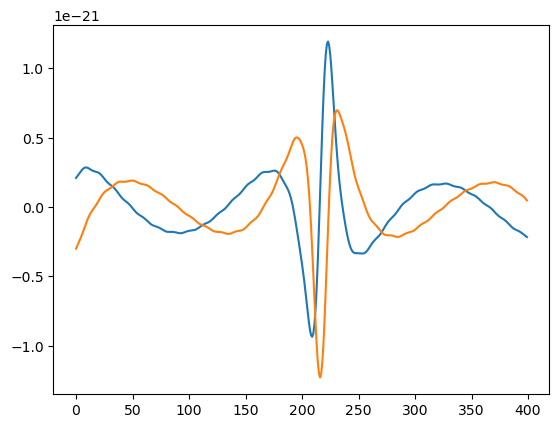

In [58]:
plt.plot(AAK_out.real[:400])
plt.plot(AAK_out.imag[:400])

### Generating the new AAK with the generic waveform generator

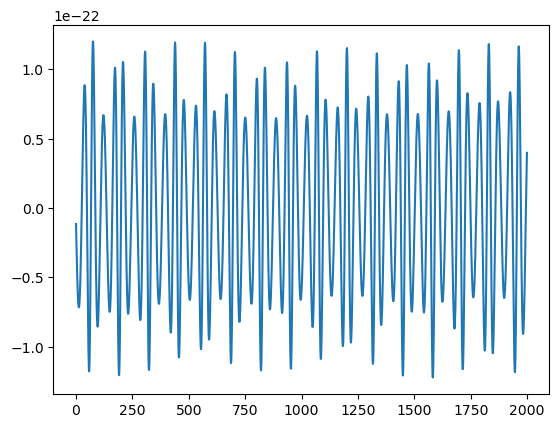

In [59]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1 
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 0.6  # notice this is x_I, not Y. The AAK waveform can convert to Y. 
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:2000])

## Mode Selection for Schwarszchild Waveforms

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute. 

### Mode selection by power contribution

In [60]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func="SchwarzEccFlux")

# parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7
theta = np.pi/3.
phi = np.pi/2.

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0)

# get amplitudes along trajectory
amp = RomanAmplitude()

teuk_modes = amp(p, e)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(amp.m0mask, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=eps)

print("We reduced the mode content from {} modes to {} modes.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 874 modes.


### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

mismatch with full wave: 0.07166765726164526


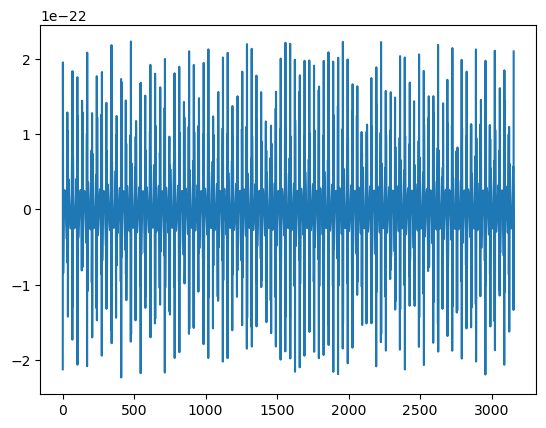

In [61]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, n) for n in range(-30, 31)]
dt = 10.0
dist = 1.0
wave_22 = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001, mode_selection=specific_modes)
wave_base = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001)

plt.plot(wave_22.real)

print('mismatch with full wave:', get_mismatch(wave_22, wave_base))

### Producing waveforms with the generic interface

Waveforms can also be generated through a generic interface ([GenerateEMRIWaveform](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.GenerateEMRIWaveform)) where the specific waveform model is chosen with an argument. This can also be used to produce waveforms in the detector frame used for data analysis. This interface includes all EMRI parameters, including spin and inclination, as well as sky and orientation parameters. When a specific waveform model does not require certain parameters, the parameters will not affect the waveform generation. A detector-frame waveform in this case means $h_+,h_x$ in the SSB-frame. 

In [62]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux")

T = 1/12/30/24  # years
dt = 15.0  # seconds

# parameters
# intrinsic
M = 1e6 
a = 0.0  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0 # in range [6+2*e0, 16]
e0 = 0.2 #
x0 = 1.0  # will be ignored in Schwarzschild waveform

# extrinsic
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.4  # azimuthal viewing angle
dist = 1.0  # distance

# initial phases
Phi_phi0 = 1.0 
Phi_theta0 = 2.0 
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

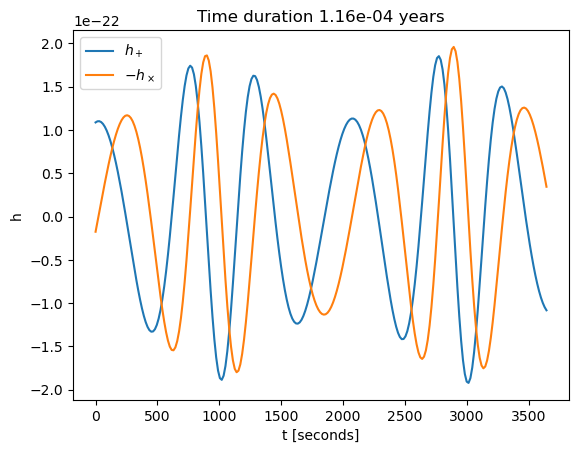

In [63]:
t = np.arange(len(h)) * dt

plt.figure()
plt.title(f'Time duration {T:.2e} years')
plt.plot(t, h.real, label=r'$h_+$')
plt.plot(t, h.imag, label=r'$-h_\times$')
plt.ylabel('h')
plt.xlabel('t [seconds]')
plt.legend()
plt.show()

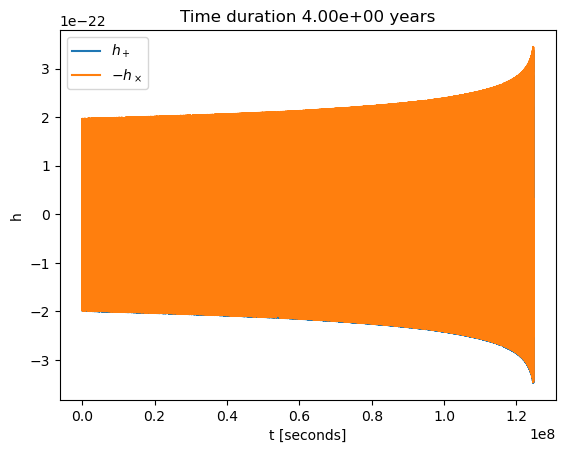

In [64]:
T = 4.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,)

t = np.arange(len(h)) * dt

plt.figure()
plt.title(f'Time duration {T:.2e} years')
plt.plot(t, h.real, label=r'$h_+$')
plt.plot(t, h.imag, label=r'$-h_\times$')
plt.ylabel('h')
plt.xlabel('t [seconds]')
plt.legend()
plt.show()

## Scaling of the waveform with the central black hole mass


100000.0 [3.577329752505046e-18]
237137.37056616554 [3.577329752505046e-18, 3.577004826483748e-18]
562341.3251903491 [3.577329752505046e-18, 3.577004826483748e-18, 3.577083417127196e-18]
1333521.432163324 [3.577329752505046e-18, 3.577004826483748e-18, 3.577083417127196e-18, 3.5771349252280955e-18]
3162277.6601683795 [3.577329752505046e-18, 3.577004826483748e-18, 3.577083417127196e-18, 3.5771349252280955e-18, 3.5771327572085345e-18]


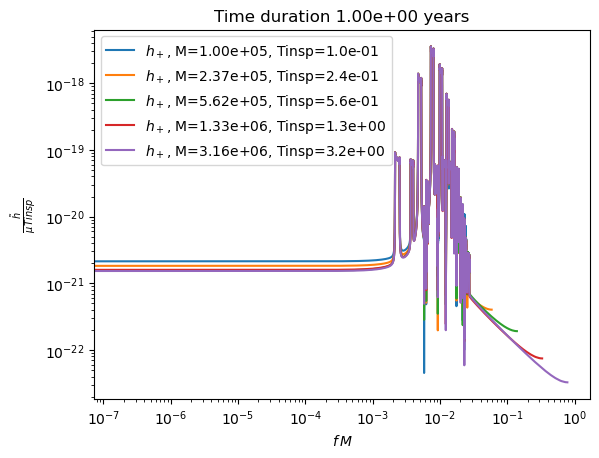

In [65]:
T = 1.0
dt=10
max_FFT = []

plt.figure()
for M in 10**np.linspace(5.0,6.5,num=5):
    mu = 1e-5*M
    Tnew = T*M/1e6
    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=Tnew,
        dt=dt,)

    t = np.arange(len(h)) * dt


    FFT= np.fft.rfft(h.real)*dt / Tnew /mu
    f= np.linspace(0.0, 1/(2*dt), num=int(len(t)/2)+1 )
    plt.loglog(f *M*MTSUN_SI, np.abs(FFT), label=fr'$h_+$, M={M:.2e}, Tinsp={Tnew:.1e}')
    max_FFT.append(np.max(np.abs(FFT)))
    print(M,max_FFT)
#     plt.plot(t, h.imag, label=r'$-h_\times$')

plt.title(f'Time duration {T:.2e} years')
plt.ylabel(r'$\frac{\tilde{h}}{\mu \, Tinsp}$')
plt.xlabel(r'$f \, M$')
plt.legend()
plt.show()

## Understanding the extrinsic parameters in the Solar System Barycenter frame

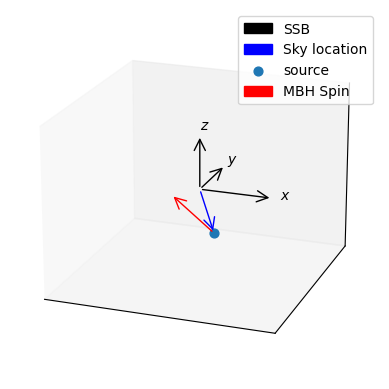

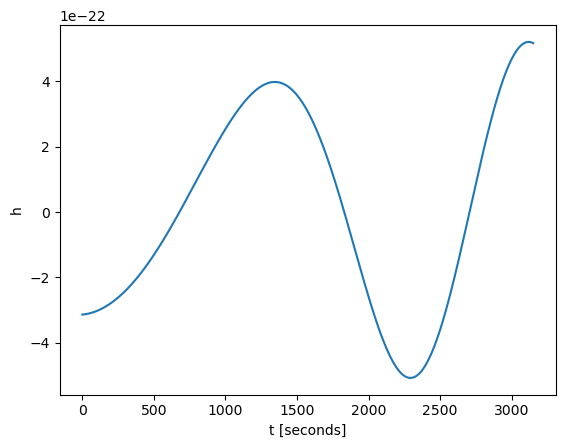

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

# draw the SSB frame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->')

a = Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict, color='k',label='SSB')
ax.add_artist(a)

ax.text(1.1, 0, 0, r'$x$')
ax.text(0, 1.1, 0, r'$y$')
ax.text(0, 0, 1.1, r'$z$')


# sky direction
qS = np.pi*0.9  # polar sky angle
phiS = 2*np.pi*0.2  # azimuthal viewing angle
th, ph, lab = qS, phiS, 'Sky location'
x_ = np.sin(th) * np.cos(ph)
y_ = np.sin(th) * np.sin(ph)
z_ = np.cos(th)
a = Arrow3D([0, x_], [0, y_], [0, z_], **arrow_prop_dict, color='blue', label=lab)
ax.add_artist(a)
ax.scatter(x_,y_,z_,s=40,label='source')

# sky spin
qK = np.pi*0.2  # polar spin angle
phiK = 2*np.pi*0.6  # azimuthal viewing angle
th, ph, lab = qK, phiK, 'MBH Spin'
x_s = np.sin(th) * np.cos(ph)
y_s = np.sin(th) * np.sin(ph)
z_s = np.cos(th)
a = Arrow3D([x_, x_+x_s], [y_, y_+y_s], [z_, z_+z_s], **arrow_prop_dict, color='red', label=lab)
ax.add_artist(a)

ax.view_init(azim=-70, elev=20)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
ax.set_zlim([-1.5,1.5])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.legend()
plt.show()

# generate waveform
T = 0.0001
h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

t = np.arange(len(h)) * dt

plt.figure()
plt.plot(t, h.real)
plt.ylabel('h')
plt.xlabel('t [seconds]')
plt.show()

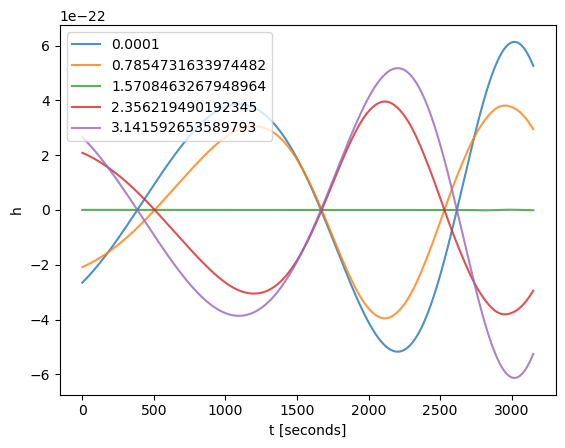

In [67]:
T = 0.0001
plt.figure()
for phase in np.linspace(1e-4, np.pi, num=5):
    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        0.0,
        np.pi/3,
        phase,
        np.pi/3,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )

    t = np.arange(len(h)) * dt


    plt.plot(t, h.imag, '-', alpha=0.8, label=f'{phase}')
    plt.ylabel('h')
    plt.xlabel('t [seconds]')
    plt.legend()
plt.show()

## Citing waveforms and modules

If you use any work from this package please cite our papers [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) and [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071). Additionally please cite any additional work for each module used by calling the `citation` attribute on the module class:

### Fast Schwarzschild Eccentric Waveforms

In [68]:
wave = FastSchwarzschildEccentricFlux()
print(wave.citation)


@article{Katz:2021yft,
    author = "Katz, Michael L. and Chua, Alvin J. K. and Speri, Lorenzo and Warburton, Niels and Hughes, Scott A.",
    title = "{FastEMRIWaveforms: New tools for millihertz gravitational-wave data analysis}",
    eprint = "2104.04582",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    month = "4",
    year = "2021"
}

@article{Chua:2020stf,
    author = "Chua, Alvin J. K. and Katz, Michael L. and Warburton, Niels and Hughes, Scott A.",
    title = "{Rapid generation of fully relativistic extreme-mass-ratio-inspiral waveform templates for LISA data analysis}",
    eprint = "2008.06071",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevLett.126.051102",
    journal = "Phys. Rev. Lett.",
    volume = "126",
    number = "5",
    pages = "051102",
    year = "2021"
}

@software{michael_l_katz_2020_4005001,
  author       = {Michael L. Katz and
                  Alvin J. K. Chua and
                  Niels Warburton and
 

### New and Improved AAK with 5PN Trajectory

In [69]:
wave_aak = Pn5AAKWaveform()
print(wave_aak.citation)


@article{Katz:2021yft,
    author = "Katz, Michael L. and Chua, Alvin J. K. and Speri, Lorenzo and Warburton, Niels and Hughes, Scott A.",
    title = "{FastEMRIWaveforms: New tools for millihertz gravitational-wave data analysis}",
    eprint = "2104.04582",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    month = "4",
    year = "2021"
}

@article{Chua:2020stf,
    author = "Chua, Alvin J. K. and Katz, Michael L. and Warburton, Niels and Hughes, Scott A.",
    title = "{Rapid generation of fully relativistic extreme-mass-ratio-inspiral waveform templates for LISA data analysis}",
    eprint = "2008.06071",
    archivePrefix = "arXiv",
    primaryClass = "gr-qc",
    doi = "10.1103/PhysRevLett.126.051102",
    journal = "Phys. Rev. Lett.",
    volume = "126",
    number = "5",
    pages = "051102",
    year = "2021"
}

@software{michael_l_katz_2020_4005001,
  author       = {Michael L. Katz and
                  Alvin J. K. Chua and
                  Niels Warburton and
 

# Solutions

## Ex 1

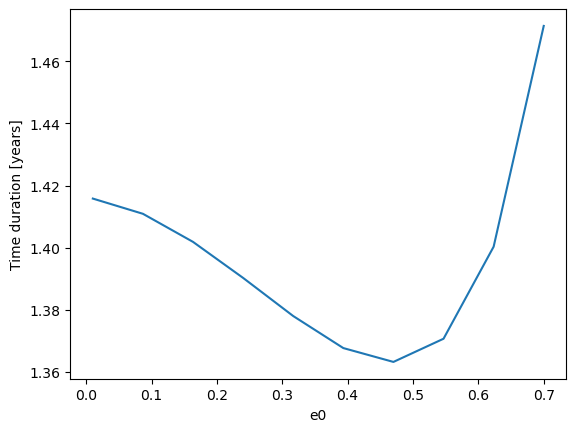

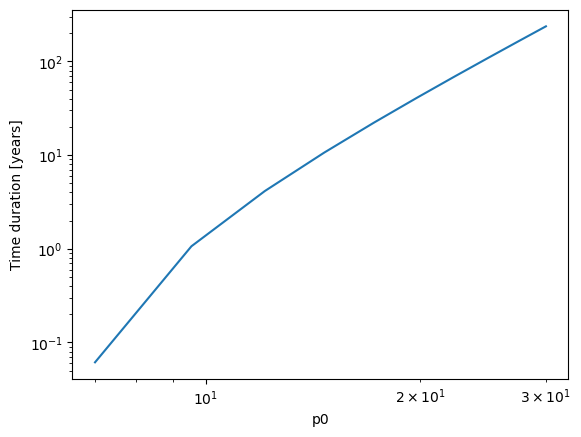

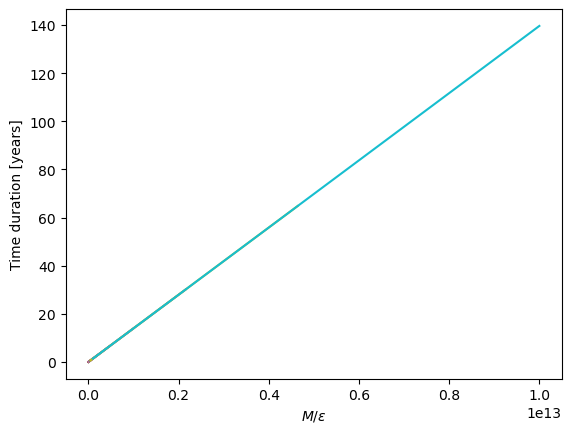

In [70]:
## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp, 
              T=1000.0,
              err=1e-10 # integrator error
             )

ecc = np.linspace(0.01, 0.7, num=10)

tfinal = []
for e0 in ecc:

    # get secondary mass for fixed mass ratio
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    
    tfinal.append(t[-1]/YRSID_SI) 


plt.figure()
plt.plot(ecc, tfinal) 
plt.ylabel('Time duration [years]')
plt.xlabel('e0')
plt.show()
############################
tfinal = []
e0 = 0.0 # reset eccentricity
pp = np.linspace(7.0, 30.0, num=10)
for p0 in pp:

    # get secondary mass for fixed mass ratio
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    
    tfinal.append(t[-1]/YRSID_SI) 


plt.figure()
plt.loglog(pp, tfinal) 
plt.ylabel('Time duration [years]')
plt.xlabel('p0')
plt.show()

############################
tfinal = []
e0 = 0.2 # reset
p0=10.0
mass_ratio_vector = 10**np.linspace(-4.0, -6.0, num=10)
Mvec = 10**np.linspace(4.0, 7.0, num=10)

plt.figure()
for M in Mvec:
    tfinal = []
    for epsilon in mass_ratio_vector:

        # get secondary mass for fixed mass ratio
        mu = M * epsilon
        t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                      Phi_phi0=0.0,
                                                      Phi_theta0=0.0,
                                                      Phi_r0=0.0,
                                                      **kwargs)

        # inspiral duration (divide by YRSID_SI to get it in years)
        tfinal.append(t[-1]/YRSID_SI) 

    plt.plot(M/mass_ratio_vector, tfinal) 
plt.ylabel('Time duration [years]')
plt.xlabel('$M/\epsilon$')
plt.show()




## Ex 2

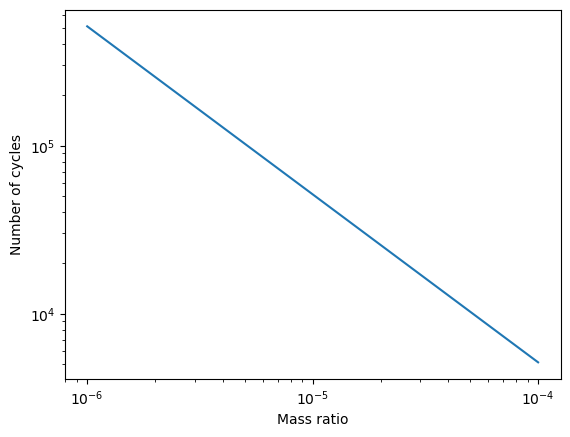

In [71]:
# set initial parameters
M = 1e6
mu = 1e1

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

Ncycle = []
for epsilon in mass_ratio_vector:

    # get secondary mass for fixed mass ratio
    mu = M * epsilon
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    
    Ncycle.append(Phi_phi[-1]/(2*np.pi)) 
    

plt.figure()
plt.loglog(mass_ratio_vector, Ncycle) 
plt.ylabel('Number of cycles')
plt.xlabel('Mass ratio')
plt.show()

## Ex 3

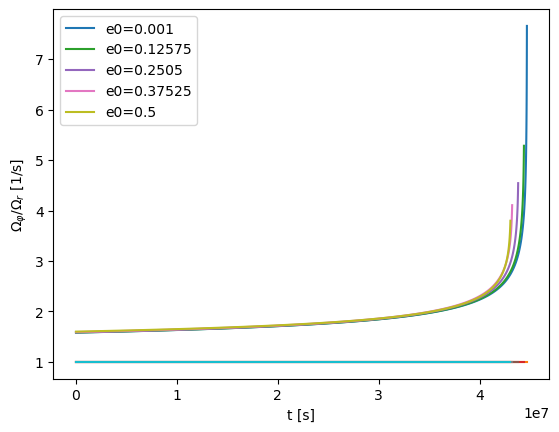

In [72]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M = 1e6
mu = 1e1
kwargs['T']=400.0
plt.figure()
for e0 in np.linspace(0.001, 0.5,num=5):
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)
    OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)
    # we need to divide by the total Mass and convert to seconds
    plt.plot(t,OmegaPhi /OmegaR , label=f'e0={e0}') 
    plt.plot(t,OmegaPhi /OmegaTheta) 


plt.ylabel(r'$\Omega_\varphi/\Omega_r$ [1/s]')
plt.xlabel('t [s]')
plt.legend()
plt.show()

## Ex 4

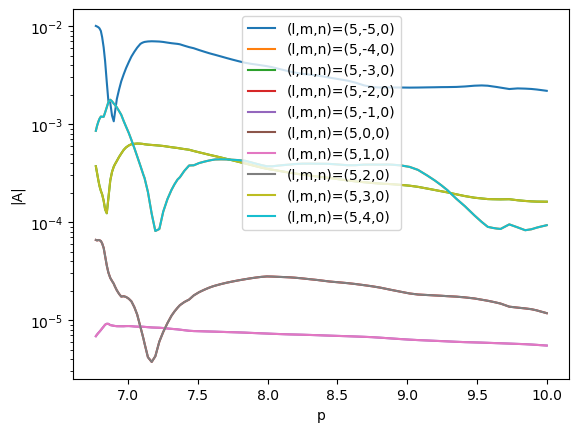

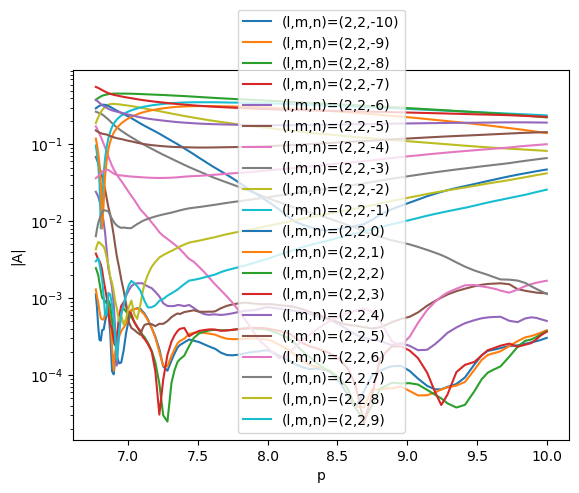

In [73]:
amp = RomanAmplitude()

teuk_modes = amp(p, e)

ll=5
plt.figure()
for mm in range(-ll,ll):
    nn=0
    plt.semilogy(p, np.abs(teuk_modes[:, amp.special_index_map[(ll,mm,nn)]]),label=f'(l,m,n)=({ll},{mm},{nn})')

plt.ylabel('|A|')
plt.xlabel('p')
plt.legend()
plt.show()

plt.figure()
for nn in range(-10,10):
    ll=2
    mm=2
    plt.semilogy(p, np.abs(teuk_modes[:, amp.special_index_map[(ll,mm,nn)]]),label=f'(l,m,n)=({ll},{mm},{nn})')

plt.ylabel('|A|')
plt.xlabel('p')
plt.legend()
plt.show()

### Ex 5

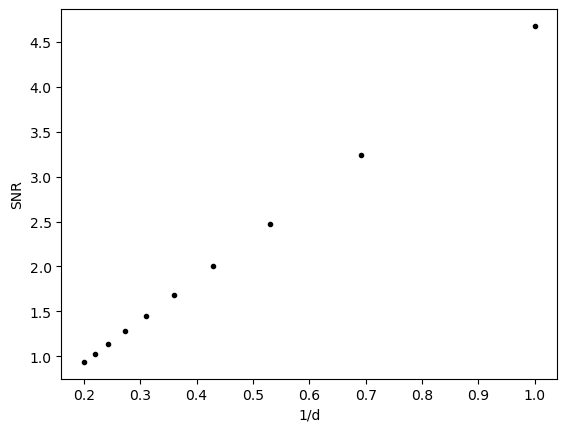

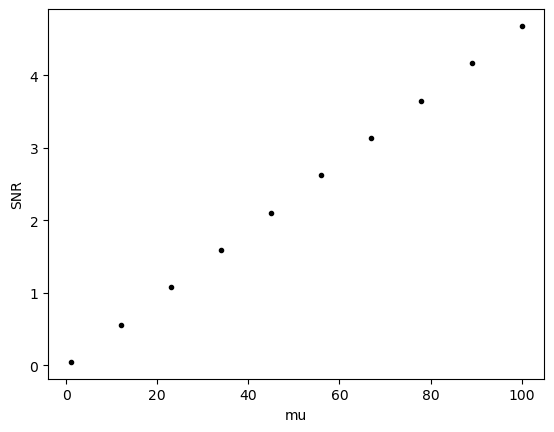

In [74]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

plt.figure()
for dd in np.linspace(1.0,5.0,num=10):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=dd, dt=dt, T=0.001)
    SNR = np.sqrt(inner_product(wave.real,wave.real,dt)+inner_product(wave.imag,wave.imag,dt))
    plt.plot(1/dd, SNR,'k.')
plt.xlabel('1/d')
plt.ylabel('SNR')
plt.show()


plt.figure()
for mu in np.linspace(1.0,100.0,num=10):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001)
    SNR = np.sqrt(inner_product(wave.real,wave.real,dt)+inner_product(wave.imag,wave.imag,dt))
    plt.plot(mu, SNR,'k.')
plt.xlabel('mu')
plt.ylabel('SNR')
plt.show()

### Ex 6

/Users/lorenzosperi/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.4.11-py3.7-macosx-10.9-x86_64.egg/few/utils/baseclasses.py:430: UserWarning: Mass ratio is outside of generally accepted range for an extreme mass ratio (1e-4). (q=0.00010000009999999998)
  mu / M
/Users/lorenzosperi/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.4.11-py3.7-macosx-10.9-x86_64.egg/few/utils/baseclasses.py:430: UserWarning: Mass ratio is outside of generally accepted range for an extreme mass ratio (1e-4). (q=0.00010000027825594021)
  mu / M
/Users/lorenzosperi/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.4.11-py3.7-macosx-10.9-x86_64.egg/few/utils/baseclasses.py:430: UserWarning: Mass ratio is outside of generally accepted range for an extreme mass ratio (1e-4). (q=0.00010000077426368267)
  mu / M
/Users/lorenzosperi/anaconda3/envs/few_env/lib/python3.7/site-packages/few-1.4.11-py3.7-macosx-10.9-x86_64.egg/few/utils/baseclasses.py:430: UserWarning: Mass ratio is outside of

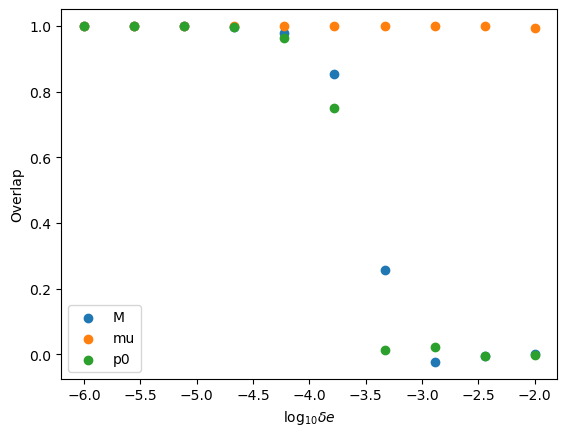

In [75]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0
T = 0.01

cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(1, 1)
axs.set_xlabel('$\log_{10}\delta e$')
axs.set_ylabel('Overlap')
vec = 10**np.linspace(-6, -2,num=10)
logd = np.log10(vec)

T=0.01
base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
# M
O=[]    
for delta in vec:
    wave = few_gen(M*(1+delta), mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'M')

# mu
O=[]    
for delta in vec:
    wave = few_gen(M, mu*(1+delta), p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'mu')

# p0
O=[]    
for delta in vec:
    wave = few_gen(M, mu, p0*(1+delta), e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'p0')


plt.legend()
plt.show()

### Ex 7

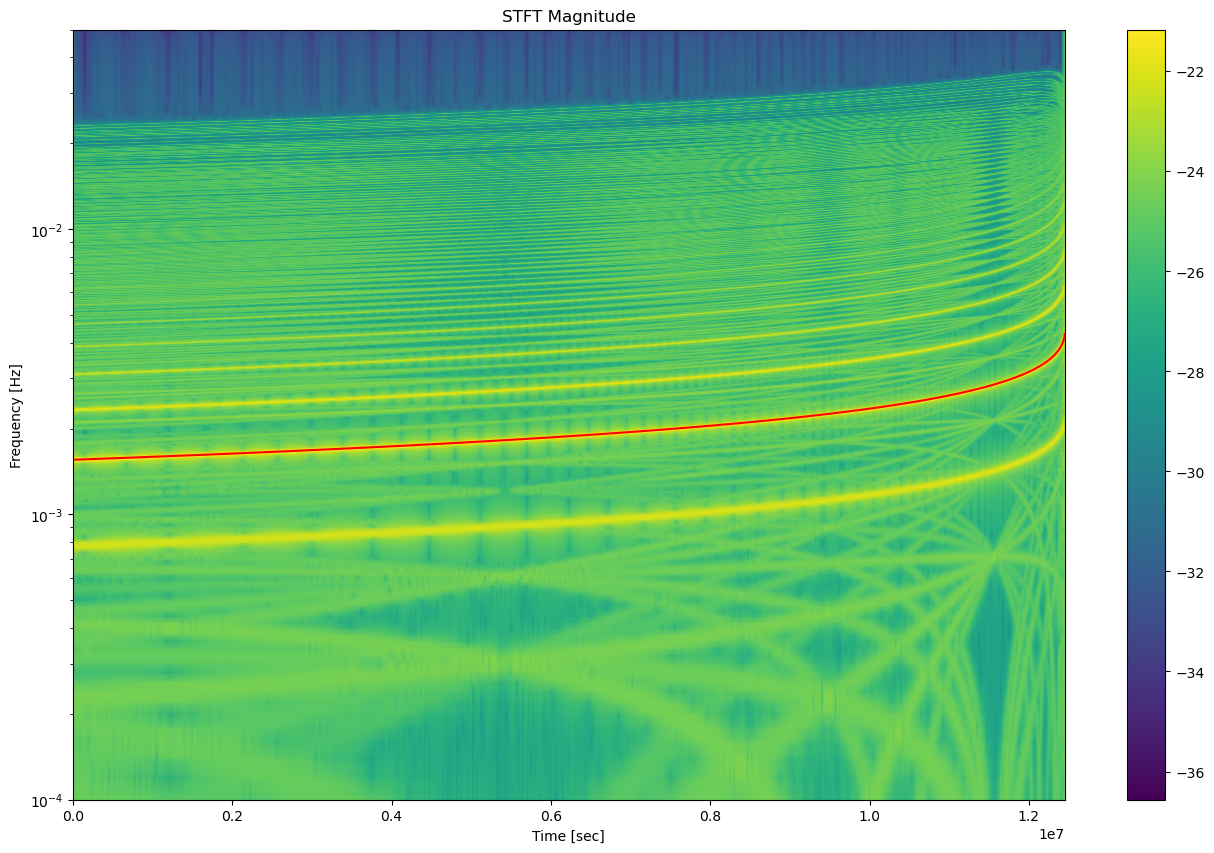

In [76]:
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.0
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)
f, t, Zxx = signal.stft(wave.real, 1/dt, nperseg=5000)

time, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=1.0, dt=dt)
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 1.0)
fharmonic = 2*OmegaPhi / (M*MTSUN_SI) / (np.pi*2)

plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
plt.plot(time, fharmonic,'r')
plt.colorbar(cb,)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([1e-4, f[-1]])

plt.show()

### Ex 8

{'dt': 10.0, 'max_init_len': 1000, 'err': 1e-10, 'DENSE_STEPPING': 0, 'use_rk4': False}
(0.0,)


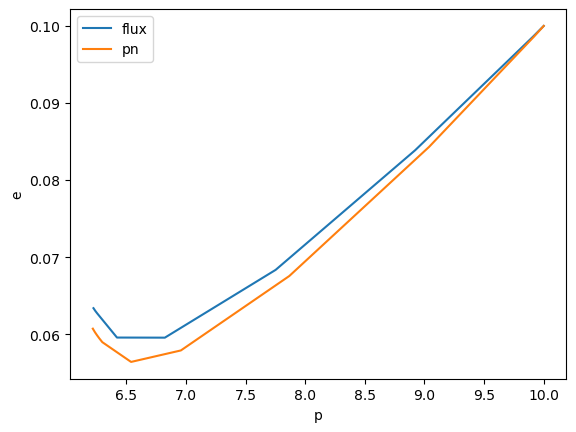

In [77]:
class BeyondPN:
    def __init__(self, epsilon, *args):
        self.epsilon = epsilon
        self.par = args[0] # additional parameter

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y

        
        # guard against bad integration steps
        if e >= 1.0 or e < 1e-6 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0, 0.0, 0.0]
        
        # perform elliptic calculations
        EllipE = ellipe(4*e/(p-6.0+2*e))
        EllipK = ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = Power(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux: here I modified the fluxes with the new parameter
        Edot = -epsilon*(EdotPN) 
        Ldot = -epsilon*(LdotPN)


        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))
        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*(18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +(-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/(e*(4*Power(e,2) - Power(-6 + p,2))*p))
        
        pdot *= 1 + self.par * p
        edot *= 1 + self.par * e
        
        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt

# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class BeyondPnTrajectory(TrajectoryBase):
    
    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass
    
    # required by the trajectory base class
    def get_inspiral(self, M, mu, a, p0, e0, x0, *args, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        # dimensionless final time
        T = T * YRSID_SI / (M * MTSUN_SI)
        
        # factor to convert back to seconds
        Msec = M * MTSUN_SI
        
        # mass ratio
        epsilon = mu/M
        
        # we define the right hand side of the ODE
        rhs = BeyondPN(epsilon, *args)
        
        # scipy integrator
        integrator = DOP853(rhs, 0.0, y0, T, atol=1e-10)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        t_out.append(0.0)
        p_out.append(p0)
        e_out.append(e0)
        Phi_phi_out.append(0.0)
        Phi_r_out.append(0.0)

        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            
            integrator.step()

            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t * Msec)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            if (p - 6 -2*e) < 0.1:
                run = False

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)
        
        # need to add polar info 
        Phi_theta = Phi_phi.copy()  # by construction
        x = np.ones_like(Phi_theta)

        return (t, p, e, x, Phi_phi, Phi_theta, Phi_r)

M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.1
T = 2.0
beta = 0.0 # we provided a new parameter

# define the trajectory
traj_new = PnTrajectory()

zero_beta = traj_new(M, mu, 0.0, p0, e0, 1.0, beta, T=T, dt=10.0)

p = zero_beta[1]
e = zero_beta[2] 

# new traj
beyond_traj = BeyondPnTrajectory()
beta=1e-2
nonzero_beta = beyond_traj(M, mu, 0.0, p0, e0, 1.0, beta, T=T, dt=10.0)

plt.plot(nonzero_beta[1], nonzero_beta[2], label='flux')
plt.plot(p, e, label='pn')
plt.ylabel('e')
plt.xlabel('p')

plt.legend()